#[ديما محمد منير القلفه - محمد وسام طارق التجار]

<h1 style="text-align: center;">Arabic Dialect Identification<h1>

Prepare libraries

In [ ]:
# here put every import you need e.g. import nltk
# it's better to load what you need from the package by from [] import [] instead of import the whole package
from google.colab import files
import zipfile
import pandas as pd
import os
!pip install datasets
from datasets import load_dataset
!pip install rarfile
import rarfile
from nltk.tokenize import TweetTokenizer
import gspread
import numpy as np
import matplotlib.pyplot as plt
!pip install wordcloud
!pip install arabic-reshaper
!pip install python-bidi
from wordcloud import WordCloud
from arabic_reshaper import reshape
from bidi.algorithm import get_display
from collections import Counter
from nltk import ngrams
import nltk
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
from nltk.collocations import TrigramCollocationFinder, TrigramAssocMeasures
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
!pip install python-bidi
import gensim.downloader as api
!pip install fasttext
import fasttext
import requests
!pip install fasttext
import io
import gensim
from gensim.models import KeyedVectors
import random
import re
import arabic_reshaper
import gzip
from matplotlib import font_manager as fm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score

from tensorflow.keras.layers import Embedding, GlobalMaxPooling1D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight
import tensorflow as tf
from scipy.interpolate import make_interp_spline as mis


Load data

# مهمة 01  : تحميل البيانات

## [1.1]

In [ ]:
# Load the QADI dataset
qadi_dataset = load_dataset("Abdelrahman-Rezk/Arabic_Dialect_Identification")

# Convert train, validation, and test splits to DataFrames
train_df = qadi_dataset['train'].to_pandas()
valid_df = qadi_dataset['validation'].to_pandas()
test_df = qadi_dataset['test'].to_pandas()


print("QADI Dataset Analysis:")
for split_name, df in zip(["Train", "Validation", "Test"], [train_df, valid_df, test_df]):
    print(f"\n{split_name} Set:")
    print(f"First 10 Rows:\n{df.head(10)}")
    print(f"Total Samples: {len(df)}")
    print(f"Duplicate Rows in `text`: {df['text'].duplicated().sum()}")
    print(f"Rows with NaN values in `text`: {df['text'].isnull().sum()}")

train_df.dropna(subset=['text'], inplace=True)
train_df.drop_duplicates(subset=['text'], inplace=True)

valid_df.dropna(subset=['text'], inplace=True)
valid_df.drop_duplicates(subset=['text'], inplace=True)

test_df.dropna(subset=['text'], inplace=True)
test_df.drop_duplicates(subset=['text'], inplace=True)


Repo card metadata block was not found. Setting CardData to empty.


QADI Dataset Analysis:

Train Set:
First 10 Rows:
                    id  label  \
0  1046024946705735552      9   
1  1140189387508134016     17   
2  1051416181855440768      0   
3   781770259422412800     11   
4   968140551366340608     11   
5  1129830890069270400      2   
6  1055146289791258624      4   
7  1040998864327794816     17   
8   966103834618744832     10   
9  1126962565261811584      2   

                                                text  
0  @Ahmed_Hamza27 اتمنى صراحة و خصوصا #طال_عمره ب...  
1  @rJiM4CnIFTgml9g @zamnissi طبعا عرفته من اللي ...  
2  @OmanisFollowers @ooredoo @TRA_OMAN @motc_om ه...  
3  كلب شو كنتوا بتتوقعوا منه !؟ \n\nمحمود عباس لا...  
4                  #عزام 🔊\nاحنا ابو الولد وام الولد  
5  @HussamAAlsaleh1 الله يبشرررررك بالجنة يابو سع...  
6  @Ocxoc @AlArabiya_Brk والله العظيم انه مجرد تق...  
7          @anasyounis52 اها مستوى أقل شوية هههههههه  
8  قلبي مقبوض ، بقالي كام يوم مش متظبط و اتمني ان...  
9            @ryanovic_nfc خوينا ذا 

In [ ]:
uploaded = files.upload()

Saving MADAR_Corpus.rar to MADAR_Corpus.rar


In [ ]:

# Ensure the rar file has been extracted
rar_filename = 'MADAR_Corpus.rar'
extract_path = '/content/Madar_Corpus'

with rarfile.RarFile(rar_filename) as rf:
    rf.extractall(extract_path)

print(f"Files extracted to {extract_path}")




Files extracted to /content/Madar_Corpus


In [ ]:
# Locate the MADAR TSV files in the extracted folder
madar_folder_path = '/content/Madar_Corpus/MADAR_Corpus'
  # Path to the extracted folder
tsv_files = [os.path.join(madar_folder_path, file) for file in os.listdir(madar_folder_path) if file.endswith('.tsv')]

# Initialize separate lists for train, validation, and test sets
train_dataframes = []
validation_dataframes = []
test_dataframes = []

# Process MADAR .tsv files
for tsv_file in tsv_files:
    df = pd.read_csv(tsv_file, sep='\t', encoding='utf-8')

    # Standardize the split column to match `train`, `validation`, `test`
    if 'split' in df.columns:
        df['split'] = df['split'].str.replace(r'corpus-6-test-corpus-\d+-train', 'train', regex=True)
        df['split'] = df['split'].str.replace(r'corpus-6-test-corpus-\d+-dev', 'validation', regex=True)
        df['split'] = df['split'].str.replace(r'corpus-6-test-corpus-\d+-test', 'test', regex=True)

        # Separate rows based on the split column
        train_dataframes.append(df[df['split'] == 'train'])
        validation_dataframes.append(df[df['split'] == 'validation'])
        test_dataframes.append(df[df['split'] == 'test'])

# Combine all subsets separately
train_combined_df = pd.concat(train_dataframes, ignore_index=True)
validation_combined_df = pd.concat(validation_dataframes, ignore_index=True)
test_combined_df = pd.concat(test_dataframes, ignore_index=True)

# Display information about the datasets
print(f"Train Set: {len(train_combined_df)} rows")
print(f"Validation Set: {len(validation_combined_df)} rows")
print(f"Test Set: {len(test_combined_df)} rows")

Train Set: 44800 rows
Validation Set: 5600 rows
Test Set: 5600 rows


## [1.2]

In [ ]:
# I replaced the numerical values in the label columns with strings from the sheet that was given in the homework
label_mapping = {
    0: 'OM', 1: 'SD', 2: 'SA', 3: 'KW', 4: 'QA', 5: 'LB',
    6: 'JO', 7: 'SY', 8: 'IQ', 9: 'MA', 10: 'EG', 11: 'PL',
    12: 'YE', 13: 'BH', 14: 'DZ', 15: 'AE', 16: 'TN', 17: 'LY'
}

# Function to replace labels with their corresponding region codes
def replace_label_with_index(df):
    """Replaces the label in a DataFrame with its corresponding region code."""
    if 'label' in df.columns:
        df['label'] = df['label'].map(label_mapping)
    else:
        print("Column 'label' not found in DataFrame.")
    return df

QADI_train = replace_label_with_index(train_df)
QADI_validation = replace_label_with_index(valid_df)
QADI_test = replace_label_with_index(test_df)

print("Mapped QADI Dataset Analysis:")
for split_name, df in zip(["Train", "Validation", "Test"], [QADI_train, QADI_validation, QADI_test]):
    print(f"\n{split_name} Set:")
    print(f"First 10 Rows:\n{df.head(10)}")
    print(f"Total Samples: {len(df)}")
    print(f"Duplicate Rows: {df.duplicated().sum()}")
    print(f"Rows with NaN values: {df.isnull().any(axis=1).sum()}")


Mapped QADI Dataset Analysis:

Train Set:
First 10 Rows:
                    id label  \
0  1046024946705735552    MA   
1  1140189387508134016    LY   
2  1051416181855440768    OM   
3   781770259422412800    PL   
4   968140551366340608    PL   
5  1129830890069270400    SA   
6  1055146289791258624    QA   
7  1040998864327794816    LY   
8   966103834618744832    EG   
9  1126962565261811584    SA   

                                                text  
0  @Ahmed_Hamza27 اتمنى صراحة و خصوصا #طال_عمره ب...  
1  @rJiM4CnIFTgml9g @zamnissi طبعا عرفته من اللي ...  
2  @OmanisFollowers @ooredoo @TRA_OMAN @motc_om ه...  
3  كلب شو كنتوا بتتوقعوا منه !؟ \n\nمحمود عباس لا...  
4                  #عزام 🔊\nاحنا ابو الولد وام الولد  
5  @HussamAAlsaleh1 الله يبشرررررك بالجنة يابو سع...  
6  @Ocxoc @AlArabiya_Brk والله العظيم انه مجرد تق...  
7          @anasyounis52 اها مستوى أقل شوية هههههههه  
8  قلبي مقبوض ، بقالي كام يوم مش متظبط و اتمني ان...  
9            @ryanovic_nfc خوينا ذا 😒 ما

In [ ]:


# Check duplicates and NaN values in the `sent` column for Train Set
train_duplicates = train_combined_df['sent'].duplicated().sum()
train_missing = train_combined_df['sent'].isnull().sum()
print(f"Train Set: {len(train_combined_df)} rows")
print(f"  Duplicated Rows in `sent`: {train_duplicates}")
print(f"  Rows with NaN values in `sent`: {train_missing}")

# Check duplicates and NaN values in the `sent` column for Validation Set
validation_duplicates = validation_combined_df['sent'].duplicated().sum()
validation_missing = validation_combined_df['sent'].isnull().sum()
print(f"Validation Set: {len(validation_combined_df)} rows")
print(f"  Duplicated Rows in `sent`: {validation_duplicates}")
print(f"  Rows with NaN values in `sent`: {validation_missing}")

# Check duplicates and NaN values in the `sent` column for Test Set
test_duplicates = test_combined_df['sent'].duplicated().sum()
test_missing = test_combined_df['sent'].isnull().sum()
print(f"Test Set: {len(test_combined_df)} rows")
print(f"  Duplicated Rows in `sent`: {test_duplicates}")
print(f"  Rows with NaN values in `sent`: {test_missing}")

display(train_combined_df.head())


Train Set: 44800 rows
  Duplicated Rows in `sent`: 6006
  Rows with NaN values in `sent`: 3200
Validation Set: 5600 rows
  Duplicated Rows in `sent`: 692
  Rows with NaN values in `sent`: 400
Test Set: 5600 rows
  Duplicated Rows in `sent`: 695
  Rows with NaN values in `sent`: 400


,sentID.BTEC,split,lang,sent
0,5,train,DAM,موجود هنيك، قدام مكتب معلومات السياح بالزبط.
1,9,train,DAM,ما سمعت بهيك عنوان هون من قبل.
2,11,train,DAM,إمشي مباشرة لحد ما تشوف صيدلية.
3,26,train,DAM,بأديش الفطور؟
4,27,train,DAM,كيف فيني ساعدك؟


In [ ]:
# Drop rows with NaN values and remove duplicated rows in the `sent` column for Train Set
train_combined_df.dropna(subset=['sent'], inplace=True)
train_combined_df.drop_duplicates(subset=['sent'], inplace=True)

# Drop rows with NaN values and remove duplicated rows in the `sent` column for Validation Set
validation_combined_df.dropna(subset=['sent'], inplace=True)
validation_combined_df.drop_duplicates(subset=['sent'], inplace=True)

# Drop rows with NaN values and remove duplicated rows in the `sent` column for Test Set
test_combined_df.dropna(subset=['sent'], inplace=True)
test_combined_df.drop_duplicates(subset=['sent'], inplace=True)

In [ ]:
# getting the sheet as a CSV file
sheet_url = "https://docs.google.com/spreadsheets/d/1TrtoaN8utbg-Op_I3vkO3CSPSYMHsxdsUpvLLm8rZME/export?format=csv"

mapping_table = pd.read_csv(sheet_url)

# Rename columns in the mapping table
mapping_table.columns = [
    'Region_Abbr', 'Region', 'Region_Arabic',
    'Country_Abbr', 'Country', 'Country_Arabic',
    'City_Abbr', 'City', 'City_Arabic'
]

# Clean the mapping table data
mapping_table['Country_Abbr'] = mapping_table['Country_Abbr'].str.strip().str.upper()

# Making sure thst labels are strings and uppercase
QADI_train['label'] = QADI_train['label'].str.strip().str.upper()

#  Merge QADI Train set with mapping table
qadi_with_classifications_train = pd.merge(
    QADI_train,
    mapping_table[['Country_Abbr', 'Region', 'Country', 'City']],
    left_on='label',
    right_on='Country_Abbr',
    how='left'
)

display("Merged QADI Train set with Classifications:\n", qadi_with_classifications_train.head())



'Merged QADI Train set with Classifications:\n'

,id,label,text,Country_Abbr,Region,Country,City
0,1046024946705735552,MA,@Ahmed_Hamza27 اتمنى صراحة و خصوصا #طال_عمره ب...,MA,Maghreb,Morocco,Rabat
1,1046024946705735552,MA,@Ahmed_Hamza27 اتمنى صراحة و خصوصا #طال_عمره ب...,MA,Maghreb,Morocco,Fes
2,1140189387508134016,LY,@rJiM4CnIFTgml9g @zamnissi طبعا عرفته من اللي ...,LY,Maghreb,Libya,Tripoli
3,1140189387508134016,LY,@rJiM4CnIFTgml9g @zamnissi طبعا عرفته من اللي ...,LY,Maghreb,Libya,Benghazi
4,1051416181855440768,OM,@OmanisFollowers @ooredoo @TRA_OMAN @motc_om ه...,OM,Gulf,Oman,Muscat


In [ ]:
#  Merge QADI Validation set with mapping table
qadi_with_classifications_validation = pd.merge(
    QADI_validation,
    mapping_table[['Country_Abbr', 'Region', 'Country', 'City']],
    left_on='label',
    right_on='Country_Abbr',
    how='left'
)

display("Merged QADI Validation set with Classifications:\n", qadi_with_classifications_validation.head())

'Merged QADI Validation set with Classifications:\n'

,id,label,text,Country_Abbr,Region,Country,City
0,910595516496515200,KW,@A_E_92 استاذ عبدالعزيز صارله الموضوع سنه يعن...,KW,Gulf,Kawait,NaN
1,847921262752129024,JO,#كذبة_نيسان كل عام والكذاب بألف خير 🙈😂 https:/...,JO,Levant,Jordan,Amman
2,847921262752129024,JO,#كذبة_نيسان كل عام والكذاب بألف خير 🙈😂 https:/...,JO,Levant,Jordan,Salt
3,1138977052055560192,EG,@basitooo5 طمطم عاااتى طبق جبنة 🙄,EG,Nile_Basin,Egypt,Cairo
4,1138977052055560192,EG,@basitooo5 طمطم عاااتى طبق جبنة 🙄,EG,Nile_Basin,Egypt,Alexandria


In [ ]:
#  Merge QADI Test set with mapping table
qadi_with_classifications_test = pd.merge(
    QADI_test,
    mapping_table[['Country_Abbr', 'Region', 'Country', 'City']],
    left_on='label',
    right_on='Country_Abbr',
    how='left'
)

display("Merged QADI Test set with Classifications:\n", qadi_with_classifications_test.head())

'Merged QADI Test set with Classifications:\n'

,id,label,text,Country_Abbr,Region,Country,City
0,1159906099585327104,EG,ايه الخيبة و الهرتلة قدام الجون دول؟؟ 🤪😲\nالعي...,EG,Nile_Basin,Egypt,Cairo
1,1159906099585327104,EG,ايه الخيبة و الهرتلة قدام الجون دول؟؟ 🤪😲\nالعي...,EG,Nile_Basin,Egypt,Alexandria
2,1159906099585327104,EG,ايه الخيبة و الهرتلة قدام الجون دول؟؟ 🤪😲\nالعي...,EG,Nile_Basin,Egypt,Aswan
3,950123809608171648,DZ,@FIA_WIS تذكرت ما اسمي عائشة انا اسمي خولة,DZ,Maghreb,Algeria,Algiers
4,950123809608171648,DZ,@FIA_WIS تذكرت ما اسمي عائشة انا اسمي خولة,DZ,Maghreb,Algeria,Annaba


In [ ]:
# Print column names for MADAR dataset
print("MADAR Dataset Column Names:")
print(f"Train Set Columns: {train_combined_df.columns.tolist()}")
print(f"Validation Set Columns: {validation_combined_df.columns.tolist()}")
print(f"Test Set Columns: {test_combined_df.columns.tolist()}")

print("\n" + "="*50 + "\n")

# Print column names for QADI dataset
print("QADI Dataset Column Names:")
print(f"Train Set Columns: {train_df.columns.tolist()}")
print(f"Validation Set Columns: {valid_df.columns.tolist()}")
print(f"Test Set Columns: {test_df.columns.tolist()}")


MADAR Dataset Column Names:
Train Set Columns: ['sentID.BTEC', 'split', 'lang', 'sent']
Validation Set Columns: ['sentID.BTEC', 'split', 'lang', 'sent']
Test Set Columns: ['sentID.BTEC', 'split', 'lang', 'sent']


QADI Dataset Column Names:
Train Set Columns: ['id', 'label', 'text']
Validation Set Columns: ['id', 'label', 'text']
Test Set Columns: ['id', 'label', 'text']


In [ ]:
# getting the sheet as a CSV file again
sheet_url = "https://docs.google.com/spreadsheets/d/1TrtoaN8utbg-Op_I3vkO3CSPSYMHsxdsUpvLLm8rZME/export?format=csv"

mapping_table = pd.read_csv(sheet_url)

# Print the current column names for reference
print("Current column names:\n", mapping_table.columns)

# Rename columns for clarity
mapping_table.columns = [
    'Region_Abbr', 'Region', 'Region_Arabic',
    'Country_Abbr', 'Country', 'Country_Arabic',
    'City_Abbr', 'City', 'City_Arabic'
]

# Clean and standardize the 'lang' column in MADAR datasets and 'City_Abbr' in the mapping table
mapping_table['City_Abbr'] = mapping_table['City_Abbr'].str.strip().str.upper()
train_combined_df['lang'] = train_combined_df['lang'].str.strip().str.upper()
validation_combined_df['lang'] = validation_combined_df['lang'].str.strip().str.upper()
test_combined_df['lang'] = test_combined_df['lang'].str.strip().str.upper()

# Merge MADAR Train set with mapping table
madar_with_classifications_train = pd.merge(
    train_combined_df,
    mapping_table[['City_Abbr', 'Region', 'Country']],
    left_on='lang',
    right_on='City_Abbr',
    how='left'
)
print("\nMerged MADAR Train Dataset with Classifications:")
display(madar_with_classifications_train.head())

Current column names:
 Index(['Unnamed: 0', 'Region', 'Unnamed: 2', 'Unnamed: 3', 'Country',
       'Unnamed: 5', 'Unnamed: 6', 'City', 'Unnamed: 8'],
      dtype='object')

Merged MADAR Train Dataset with Classifications:


,sentID.BTEC,split,lang,sent,City_Abbr,Region,Country
0,5,train,DAM,موجود هنيك، قدام مكتب معلومات السياح بالزبط.,DAM,Levant,Syria
1,9,train,DAM,ما سمعت بهيك عنوان هون من قبل.,DAM,Levant,Syria
2,11,train,DAM,إمشي مباشرة لحد ما تشوف صيدلية.,DAM,Levant,Syria
3,26,train,DAM,بأديش الفطور؟,DAM,Levant,Syria
4,27,train,DAM,كيف فيني ساعدك؟,DAM,Levant,Syria


In [ ]:
# Merge MADAR Validation set with mapping table
madar_with_classifications_validation = pd.merge(
    validation_combined_df,
    mapping_table[['City_Abbr', 'Region', 'Country']],
    left_on='lang',
    right_on='City_Abbr',
    how='left'
)
print("\nMerged MADAR Validation set with Classifications:")
display(madar_with_classifications_validation.head())




Merged MADAR Validation set with Classifications:


,sentID.BTEC,split,lang,sent,City_Abbr,Region,Country
0,398,validation,DAM,بالمناسبة، اسمي هيروشي ايجيما.,DAM,Levant,Syria
1,401,validation,DAM,هاد القطار بوقف بليك فورست، صح؟,DAM,Levant,Syria
2,471,validation,DAM,هاد الكرت، تمام؟,DAM,Levant,Syria
3,652,validation,DAM,ما طلع شي من المكنة؟,DAM,Levant,Syria
4,741,validation,DAM,في شي ممكن آخده لعلاج هاد الطفح؟,DAM,Levant,Syria


In [ ]:
# Merge MADAR Test set with mapping table
madar_with_classifications_test = pd.merge(
    test_combined_df,
    mapping_table[['City_Abbr', 'Region', 'Country']],
    left_on='lang',
    right_on='City_Abbr',
    how='left'
)

print("\nMerged MADAR Test set with Classifications:")
display(madar_with_classifications_test.head())


Merged MADAR Test set with Classifications:


,sentID.BTEC,split,lang,sent,City_Abbr,Region,Country
0,120,test,DAM,لو كنت مكانك كنت اشتريته.,DAM,Levant,Syria
1,173,test,DAM,بعتذر. هالمكان محجوز.,DAM,Levant,Syria
2,177,test,DAM,شكراً. هيك بكفي.,DAM,Levant,Syria
3,333,test,DAM,رجاءً حولي هدول الينات لجنيهات.,DAM,Levant,Syria
4,373,test,DAM,ساكن قريب من هون؟,DAM,Levant,Syria


In [ ]:
# Rename the 'text' column to 'sent' in QADI datasets
qadi_with_classifications_train.rename(columns={'text': 'sent'}, inplace=True)
qadi_with_classifications_validation.rename(columns={'text': 'sent'}, inplace=True)
qadi_with_classifications_test.rename(columns={'text': 'sent'}, inplace=True)

# Display the updated column names
display("Updated QADI Train Columns:", qadi_with_classifications_train.columns)
display("Updated QADI Validation Columns:", qadi_with_classifications_validation.columns)
display("Updated QADI Test Columns:", qadi_with_classifications_validation.columns)


'Updated QADI Train Columns:'

Index(['id', 'label', 'sent', 'Country_Abbr', 'Region', 'Country', 'City'], dtype='object')

'Updated QADI Validation Columns:'

Index(['id', 'label', 'sent', 'Country_Abbr', 'Region', 'Country', 'City'], dtype='object')

'Updated QADI Test Columns:'

Index(['id', 'label', 'sent', 'Country_Abbr', 'Region', 'Country', 'City'], dtype='object')

In [ ]:
print("QADI Train Columns:", qadi_with_classifications_train.columns)
print("Madar Train Columns:", madar_with_classifications_train.columns)


qadi_with_classifications_train.columns = qadi_with_classifications_train.columns.str.strip().str.upper()
madar_with_classifications_train.columns = madar_with_classifications_train.columns.str.strip().str.upper()




QADI Train Columns: Index(['id', 'label', 'sent', 'Country_Abbr', 'Region', 'Country', 'City'], dtype='object')
Madar Train Columns: Index(['sentID.BTEC', 'split', 'lang', 'sent', 'City_Abbr', 'Region',
       'Country'],
      dtype='object')


## [1.3]

In [ ]:

# Add an identifier column 'source'
qadi_with_classifications_train['source'] = 'QADI'
qadi_with_classifications_validation['source'] = 'QADI'
qadi_with_classifications_test['source'] = 'QADI'

madar_with_classifications_train['source'] = 'Madar'
madar_with_classifications_validation['source'] = 'Madar'
madar_with_classifications_test['source'] = 'Madar'

# Merge the datasets
merged_train = pd.concat([qadi_with_classifications_train, madar_with_classifications_train], ignore_index=True)
merged_validation = pd.concat([qadi_with_classifications_validation, madar_with_classifications_validation], ignore_index=True)
merged_test = pd.concat([qadi_with_classifications_test, madar_with_classifications_test], ignore_index=True)

# Set City_Abbr to NaN for QADI
merged_train.loc[merged_train['source'] == 'QADI', 'City_Abbr'] = np.nan
merged_validation.loc[merged_validation['source'] == 'QADI', 'City_Abbr'] = np.nan
merged_test.loc[merged_test['source'] == 'QADI', 'City_Abbr'] = np.nan


# results
print("Merged Train Shape:", merged_train.shape)
print("Merged Validation Shape:", merged_validation.shape)
print("Merged Test Shape:", merged_test.shape)

display(merged_train.head(10))
display(merged_validation.head())
display(merged_test.head())

# Print the number of rows in the merged_train DataFrame
print(f"Number of rows in merged_train: {len(merged_train)}")


Merged Train Shape: (800068, 13)
Merged Validation Shape: (20762, 12)
Merged Test Shape: (20441, 12)


,ID,LABEL,SENT,COUNTRY_ABBR,REGION,COUNTRY,CITY,source,SENTID.BTEC,SPLIT,LANG,CITY_ABBR,City_Abbr
0,1.046025e+18,MA,@Ahmed_Hamza27 اتمنى صراحة و خصوصا #طال_عمره ب...,MA,Maghreb,Morocco,Rabat,QADI,NaN,NaN,NaN,NaN,NaN
1,1.046025e+18,MA,@Ahmed_Hamza27 اتمنى صراحة و خصوصا #طال_عمره ب...,MA,Maghreb,Morocco,Fes,QADI,NaN,NaN,NaN,NaN,NaN
2,1.140189e+18,LY,@rJiM4CnIFTgml9g @zamnissi طبعا عرفته من اللي ...,LY,Maghreb,Libya,Tripoli,QADI,NaN,NaN,NaN,NaN,NaN
3,1.140189e+18,LY,@rJiM4CnIFTgml9g @zamnissi طبعا عرفته من اللي ...,LY,Maghreb,Libya,Benghazi,QADI,NaN,NaN,NaN,NaN,NaN
4,1.051416e+18,OM,@OmanisFollowers @ooredoo @TRA_OMAN @motc_om ه...,OM,Gulf,Oman,Muscat,QADI,NaN,NaN,NaN,NaN,NaN
5,7.817703e+17,PL,كلب شو كنتوا بتتوقعوا منه !؟ \n\nمحمود عباس لا...,PL,Levant,Palestine,Jerusalem,QADI,NaN,NaN,NaN,NaN,NaN
6,7.817703e+17,PL,كلب شو كنتوا بتتوقعوا منه !؟ \n\nمحمود عباس لا...,PL,Levant,Palestine,Gaza,QADI,NaN,NaN,NaN,NaN,NaN
7,9.681406e+17,PL,#عزام 🔊\nاحنا ابو الولد وام الولد,PL,Levant,Palestine,Jerusalem,QADI,NaN,NaN,NaN,NaN,NaN
8,9.681406e+17,PL,#عزام 🔊\nاحنا ابو الولد وام الولد,PL,Levant,Palestine,Gaza,QADI,NaN,NaN,NaN,NaN,NaN
9,1.129831e+18,SA,@HussamAAlsaleh1 الله يبشرررررك بالجنة يابو سع...,SA,Gulf,Saudi Arabia,Riyadh,QADI,NaN,NaN,NaN,NaN,NaN


,id,label,sent,Country_Abbr,Region,Country,City,source,sentID.BTEC,split,lang,City_Abbr
0,9.105955e+17,KW,@A_E_92 استاذ عبدالعزيز صارله الموضوع سنه يعن...,KW,Gulf,Kawait,NaN,QADI,NaN,NaN,NaN,NaN
1,8.479213e+17,JO,#كذبة_نيسان كل عام والكذاب بألف خير 🙈😂 https:/...,JO,Levant,Jordan,Amman,QADI,NaN,NaN,NaN,NaN
2,8.479213e+17,JO,#كذبة_نيسان كل عام والكذاب بألف خير 🙈😂 https:/...,JO,Levant,Jordan,Salt,QADI,NaN,NaN,NaN,NaN
3,1.138977e+18,EG,@basitooo5 طمطم عاااتى طبق جبنة 🙄,EG,Nile_Basin,Egypt,Cairo,QADI,NaN,NaN,NaN,NaN
4,1.138977e+18,EG,@basitooo5 طمطم عاااتى طبق جبنة 🙄,EG,Nile_Basin,Egypt,Alexandria,QADI,NaN,NaN,NaN,NaN


,id,label,sent,Country_Abbr,Region,Country,City,source,sentID.BTEC,split,lang,City_Abbr
0,1.159906e+18,EG,ايه الخيبة و الهرتلة قدام الجون دول؟؟ 🤪😲\nالعي...,EG,Nile_Basin,Egypt,Cairo,QADI,NaN,NaN,NaN,NaN
1,1.159906e+18,EG,ايه الخيبة و الهرتلة قدام الجون دول؟؟ 🤪😲\nالعي...,EG,Nile_Basin,Egypt,Alexandria,QADI,NaN,NaN,NaN,NaN
2,1.159906e+18,EG,ايه الخيبة و الهرتلة قدام الجون دول؟؟ 🤪😲\nالعي...,EG,Nile_Basin,Egypt,Aswan,QADI,NaN,NaN,NaN,NaN
3,9.501238e+17,DZ,@FIA_WIS تذكرت ما اسمي عائشة انا اسمي خولة,DZ,Maghreb,Algeria,Algiers,QADI,NaN,NaN,NaN,NaN
4,9.501238e+17,DZ,@FIA_WIS تذكرت ما اسمي عائشة انا اسمي خولة,DZ,Maghreb,Algeria,Annaba,QADI,NaN,NaN,NaN,NaN


Number of rows in merged_train: 800068


In [ ]:
# Drop the 'source' column
merged_train.drop(columns=['source'], inplace=True)
merged_validation.drop(columns=['source'], inplace=True)
merged_test.drop(columns=['source'], inplace=True)

display(merged_train.head(10))
display(merged_validation.head())
display(merged_test.head())


,ID,LABEL,SENT,COUNTRY_ABBR,REGION,COUNTRY,CITY,SENTID.BTEC,SPLIT,LANG,CITY_ABBR,City_Abbr
0,1.046025e+18,MA,@Ahmed_Hamza27 اتمنى صراحة و خصوصا #طال_عمره ب...,MA,Maghreb,Morocco,Rabat,NaN,NaN,NaN,NaN,NaN
1,1.046025e+18,MA,@Ahmed_Hamza27 اتمنى صراحة و خصوصا #طال_عمره ب...,MA,Maghreb,Morocco,Fes,NaN,NaN,NaN,NaN,NaN
2,1.140189e+18,LY,@rJiM4CnIFTgml9g @zamnissi طبعا عرفته من اللي ...,LY,Maghreb,Libya,Tripoli,NaN,NaN,NaN,NaN,NaN
3,1.140189e+18,LY,@rJiM4CnIFTgml9g @zamnissi طبعا عرفته من اللي ...,LY,Maghreb,Libya,Benghazi,NaN,NaN,NaN,NaN,NaN
4,1.051416e+18,OM,@OmanisFollowers @ooredoo @TRA_OMAN @motc_om ه...,OM,Gulf,Oman,Muscat,NaN,NaN,NaN,NaN,NaN
5,7.817703e+17,PL,كلب شو كنتوا بتتوقعوا منه !؟ \n\nمحمود عباس لا...,PL,Levant,Palestine,Jerusalem,NaN,NaN,NaN,NaN,NaN
6,7.817703e+17,PL,كلب شو كنتوا بتتوقعوا منه !؟ \n\nمحمود عباس لا...,PL,Levant,Palestine,Gaza,NaN,NaN,NaN,NaN,NaN
7,9.681406e+17,PL,#عزام 🔊\nاحنا ابو الولد وام الولد,PL,Levant,Palestine,Jerusalem,NaN,NaN,NaN,NaN,NaN
8,9.681406e+17,PL,#عزام 🔊\nاحنا ابو الولد وام الولد,PL,Levant,Palestine,Gaza,NaN,NaN,NaN,NaN,NaN
9,1.129831e+18,SA,@HussamAAlsaleh1 الله يبشرررررك بالجنة يابو سع...,SA,Gulf,Saudi Arabia,Riyadh,NaN,NaN,NaN,NaN,NaN


,id,label,sent,Country_Abbr,Region,Country,City,sentID.BTEC,split,lang,City_Abbr
0,9.105955e+17,KW,@A_E_92 استاذ عبدالعزيز صارله الموضوع سنه يعن...,KW,Gulf,Kawait,NaN,NaN,NaN,NaN,NaN
1,8.479213e+17,JO,#كذبة_نيسان كل عام والكذاب بألف خير 🙈😂 https:/...,JO,Levant,Jordan,Amman,NaN,NaN,NaN,NaN
2,8.479213e+17,JO,#كذبة_نيسان كل عام والكذاب بألف خير 🙈😂 https:/...,JO,Levant,Jordan,Salt,NaN,NaN,NaN,NaN
3,1.138977e+18,EG,@basitooo5 طمطم عاااتى طبق جبنة 🙄,EG,Nile_Basin,Egypt,Cairo,NaN,NaN,NaN,NaN
4,1.138977e+18,EG,@basitooo5 طمطم عاااتى طبق جبنة 🙄,EG,Nile_Basin,Egypt,Alexandria,NaN,NaN,NaN,NaN


,id,label,sent,Country_Abbr,Region,Country,City,sentID.BTEC,split,lang,City_Abbr
0,1.159906e+18,EG,ايه الخيبة و الهرتلة قدام الجون دول؟؟ 🤪😲\nالعي...,EG,Nile_Basin,Egypt,Cairo,NaN,NaN,NaN,NaN
1,1.159906e+18,EG,ايه الخيبة و الهرتلة قدام الجون دول؟؟ 🤪😲\nالعي...,EG,Nile_Basin,Egypt,Alexandria,NaN,NaN,NaN,NaN
2,1.159906e+18,EG,ايه الخيبة و الهرتلة قدام الجون دول؟؟ 🤪😲\nالعي...,EG,Nile_Basin,Egypt,Aswan,NaN,NaN,NaN,NaN
3,9.501238e+17,DZ,@FIA_WIS تذكرت ما اسمي عائشة انا اسمي خولة,DZ,Maghreb,Algeria,Algiers,NaN,NaN,NaN,NaN
4,9.501238e+17,DZ,@FIA_WIS تذكرت ما اسمي عائشة انا اسمي خولة,DZ,Maghreb,Algeria,Annaba,NaN,NaN,NaN,NaN


In [ ]:
# Drop the 'id' and 'sentID.BTEC' columns
merged_train.drop(columns=['id', 'SENTID.BTEC'], inplace=True, errors='ignore')
merged_validation.drop(columns=['id', 'sentID.BTEC'], inplace=True, errors='ignore')
merged_test.drop(columns=['id', 'sentID.BTEC'], inplace=True, errors='ignore')

display(merged_train.head())
display(merged_validation.head())
display(merged_test.head())
# Print the number of rows in the merged_train DataFrame
print(f"Number of rows in merged_train: {len(merged_train)}")


,ID,LABEL,SENT,COUNTRY_ABBR,REGION,COUNTRY,CITY,SPLIT,LANG,CITY_ABBR,City_Abbr
0,1.046025e+18,MA,@Ahmed_Hamza27 اتمنى صراحة و خصوصا #طال_عمره ب...,MA,Maghreb,Morocco,Rabat,NaN,NaN,NaN,NaN
1,1.046025e+18,MA,@Ahmed_Hamza27 اتمنى صراحة و خصوصا #طال_عمره ب...,MA,Maghreb,Morocco,Fes,NaN,NaN,NaN,NaN
2,1.140189e+18,LY,@rJiM4CnIFTgml9g @zamnissi طبعا عرفته من اللي ...,LY,Maghreb,Libya,Tripoli,NaN,NaN,NaN,NaN
3,1.140189e+18,LY,@rJiM4CnIFTgml9g @zamnissi طبعا عرفته من اللي ...,LY,Maghreb,Libya,Benghazi,NaN,NaN,NaN,NaN
4,1.051416e+18,OM,@OmanisFollowers @ooredoo @TRA_OMAN @motc_om ه...,OM,Gulf,Oman,Muscat,NaN,NaN,NaN,NaN


,label,sent,Country_Abbr,Region,Country,City,split,lang,City_Abbr
0,KW,@A_E_92 استاذ عبدالعزيز صارله الموضوع سنه يعن...,KW,Gulf,Kawait,NaN,NaN,NaN,NaN
1,JO,#كذبة_نيسان كل عام والكذاب بألف خير 🙈😂 https:/...,JO,Levant,Jordan,Amman,NaN,NaN,NaN
2,JO,#كذبة_نيسان كل عام والكذاب بألف خير 🙈😂 https:/...,JO,Levant,Jordan,Salt,NaN,NaN,NaN
3,EG,@basitooo5 طمطم عاااتى طبق جبنة 🙄,EG,Nile_Basin,Egypt,Cairo,NaN,NaN,NaN
4,EG,@basitooo5 طمطم عاااتى طبق جبنة 🙄,EG,Nile_Basin,Egypt,Alexandria,NaN,NaN,NaN


,label,sent,Country_Abbr,Region,Country,City,split,lang,City_Abbr
0,EG,ايه الخيبة و الهرتلة قدام الجون دول؟؟ 🤪😲\nالعي...,EG,Nile_Basin,Egypt,Cairo,NaN,NaN,NaN
1,EG,ايه الخيبة و الهرتلة قدام الجون دول؟؟ 🤪😲\nالعي...,EG,Nile_Basin,Egypt,Alexandria,NaN,NaN,NaN
2,EG,ايه الخيبة و الهرتلة قدام الجون دول؟؟ 🤪😲\nالعي...,EG,Nile_Basin,Egypt,Aswan,NaN,NaN,NaN
3,DZ,@FIA_WIS تذكرت ما اسمي عائشة انا اسمي خولة,DZ,Maghreb,Algeria,Algiers,NaN,NaN,NaN
4,DZ,@FIA_WIS تذكرت ما اسمي عائشة انا اسمي خولة,DZ,Maghreb,Algeria,Annaba,NaN,NaN,NaN


Number of rows in merged_train: 800068


# مهمة 02 : فهم وتحليل البيانات

EDA

## [2.1]


In [ ]:

# Count texts per region
region_counts = merged_train['REGION'].value_counts()

# Count texts per country
country_counts = merged_train['COUNTRY'].value_counts()

# Count texts per city
city_counts = merged_train['CITY'].value_counts()

# Display
print("Number of texts per Region:")
display(region_counts)

print("\nNumber of texts per Country:")
display(country_counts)

print("\nNumber of texts per City:")
display(city_counts)


Number of texts per Region:


,count
REGION,
Levant,204151
Gulf,196369
Nile_Basin,185961
Maghreb,151754
Iraqi,49146
Yemen,11094



Number of texts per Country:


,count
COUNTRY,
Egypt,170595
Palestine,85512
Libya,73060
Jordan,56474
Saudi Arabia,54418
Iraq,49146
Kawait,40442
Syria,34166
Algeria,32630



Number of texts per City:


,count
CITY,
Alexandria,55353
Cairo,55353
Aswan,55353
Jerusalem,42010
Gaza,42010
Tripoli,35053
Benghazi,35053
Doha,29839
Amman,26816


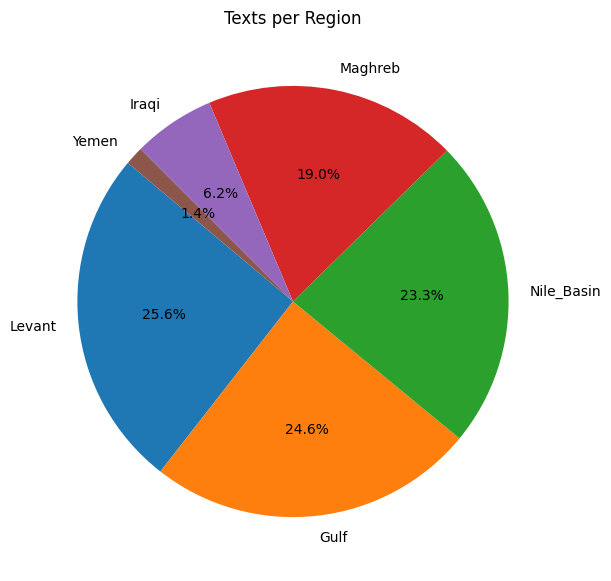

In [ ]:
# Pie chart for Region
plt.figure(figsize=(10, 7))
region_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140, title='Texts per Region', ylabel='')
plt.show()


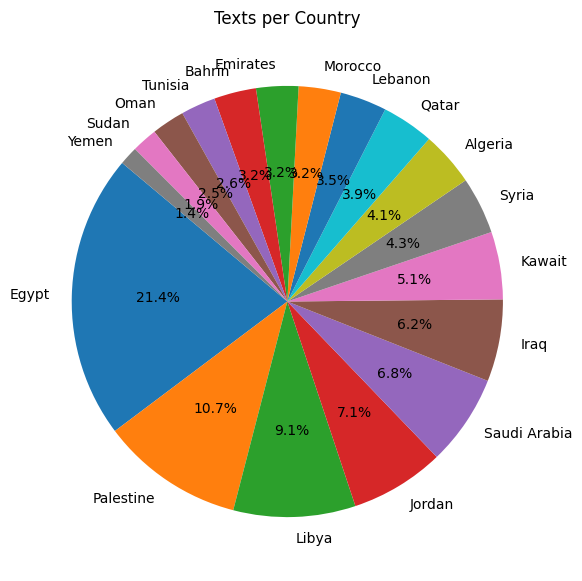

In [ ]:
 # Pie chart for Country
plt.figure(figsize=(10, 7))
country_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140, title='Texts per Country', ylabel='')
plt.show()

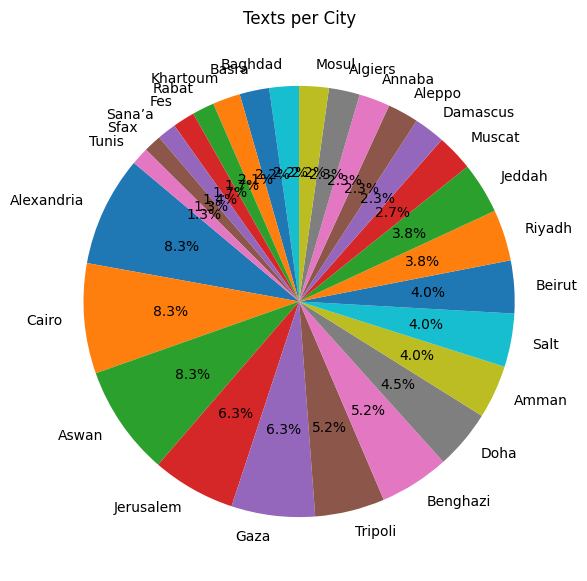

In [ ]:
# Pie chart for City
plt.figure(figsize=(10, 7))
city_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140, title='Texts per City', ylabel='')
plt.show()

التوزيع غير متوازن . المدن الكبرى مثل القاهرة و  الاسكندرية و أسوان تمثل نسبة كبيرة بينما المن الأخرى مثل الموصل و الجزائر و عنابة تمثل نسبة صغيرة
النموذج قد يتعلم بشكل جيد خصائص المدن و البلدان ذات التمثيل العالي.
قد يفشل في التعميم على النصوص الخاصة بالمدن ذات التمثيل المنخفض

## [2.2]

In [ ]:

# Initialize the TweetTokenizer
tokenizer = TweetTokenizer()

# Ensure the 'sent' column is treated as string
merged_train['SENT'] = merged_train['SENT'].astype(str)

# Apply tokenization to each sentence
merged_train['tokens'] = merged_train['SENT'].apply(tokenizer.tokenize)

# Flatten the list of tokenized words for all sentences
tokens = [token for sublist in merged_train['tokens'] for token in sublist]

# Calculate the total number of tokens and unique words
total_tokens = len(tokens)
unique_words = len(set(tokens))

# Display sentences with their tokens
print("First five sentences with tokens:")
display(merged_train[['SENT', 'tokens']].head())

# Print token statistics
print(f"\nTotal number of tokens: {total_tokens}")
print(f"Total number of unique words: {unique_words}")

# Print the number of rows in the merged_train DataFrame
print(f"Number of rows in merged_train: {len(merged_train)}")


First five sentences with tokens:


,SENT,tokens
0,@Ahmed_Hamza27 اتمنى صراحة و خصوصا #طال_عمره ب...,"[@Ahmed_Hamza27, اتمنى, صراحة, و, خصوصا, #طال_..."
1,@Ahmed_Hamza27 اتمنى صراحة و خصوصا #طال_عمره ب...,"[@Ahmed_Hamza27, اتمنى, صراحة, و, خصوصا, #طال_..."
2,@rJiM4CnIFTgml9g @zamnissi طبعا عرفته من اللي ...,"[@rJiM4CnIFTgml9g, @zamnissi, طبعا, عرفته, من,..."
3,@rJiM4CnIFTgml9g @zamnissi طبعا عرفته من اللي ...,"[@rJiM4CnIFTgml9g, @zamnissi, طبعا, عرفته, من,..."
4,@OmanisFollowers @ooredoo @TRA_OMAN @motc_om ه...,"[@OmanisFollowers, @ooredoo, @TRA_OMAN, @motc_..."



Total number of tokens: 12459867
Total number of unique words: 721148
Number of rows in merged_train: 800068


## [2.3]

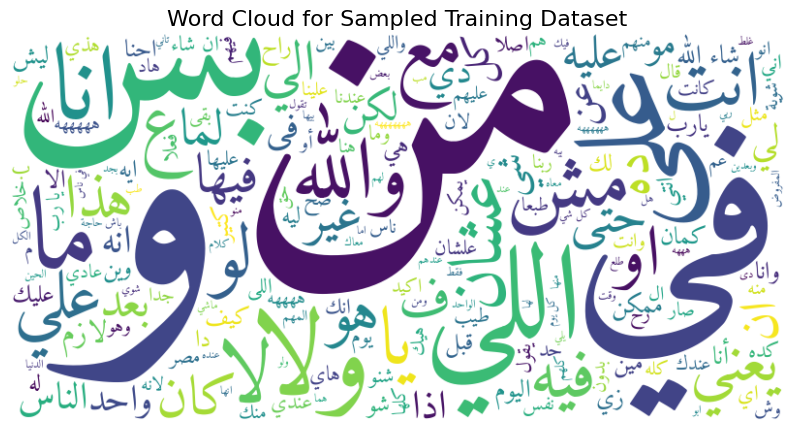

Number of rows in merged_train: 800068


In [ ]:
# Sample randomly
sample_size = 200000
sampled_text = " ".join(random.sample(merged_train['SENT'].dropna().astype(str).tolist(), sample_size))

# Keep only Arabic characters and spaces
sampled_text = re.sub(r'[^\u0600-\u06FF\s]', '', sampled_text)

# Reshape Arabic letters
reshaped_text = reshape(sampled_text)
display_text = get_display(reshaped_text)

# Path to the font
font_path = "/content/Amiri-Regular.ttf"

# Generate Word Cloud
wordcloud = WordCloud(
    font_path=font_path,
    background_color='white',
    width=800,
    height=400,
    colormap='viridis',
    mode="RGB"
).generate(reshaped_text)

# Display
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Sampled Training Dataset', fontsize=16)
plt.show()


# Print the number of rows in the merged_train DataFrame
print(f"Number of rows in merged_train: {len(merged_train)}")



## [2.4]

In [ ]:
# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')

def analyze_text_features_original(dataset, column_name, top_n=20, bottom_n=20):
    # Flatten the list of tokens into a single list
    all_tokens = [token for tokens_list in dataset[column_name] for token in tokens_list]

    # Unique words
    unique_words = set(all_tokens)

    # Most frequent words
    word_counts = Counter(all_tokens)
    most_frequent_words = word_counts.most_common(top_n)

    # Least frequent words
    least_frequent_words = word_counts.most_common()[-bottom_n:]

    # Bigrams
    bigram_finder = BigramCollocationFinder.from_words(all_tokens)
    bigram_finder.apply_freq_filter(10)
    most_frequent_bigrams = Counter(bigram_finder.ngram_fd).most_common(top_n)

    # Bigram collocations
    bigram_collocations = []
    for bigram, score in tqdm(bigram_finder.score_ngrams(BigramAssocMeasures.likelihood_ratio)[:top_n]):
        bigram_collocations.append((bigram, score))

    # Trigrams
    trigram_finder = TrigramCollocationFinder.from_words(all_tokens)
    trigram_finder.apply_freq_filter(10)
    most_frequent_trigrams = Counter(trigram_finder.ngram_fd).most_common(top_n)

    # Trigram collocations
    trigram_collocations = []
    for trigram, score in tqdm(trigram_finder.score_ngrams(TrigramAssocMeasures.likelihood_ratio)[:top_n]):
        trigram_collocations.append((trigram, score))

    # Create DataFrames for display
    results = {
        'unique_words': unique_words,
        'most_frequent_words': pd.DataFrame(most_frequent_words, columns=['Word', 'Frequency']),
        'least_frequent_words': pd.DataFrame(least_frequent_words, columns=['Word', 'Frequency']),
        'most_frequent_bigrams': pd.DataFrame(most_frequent_bigrams, columns=['Bigram', 'Frequency']),
        'bigram_collocations': pd.DataFrame(bigram_collocations, columns=['Bigram', 'Score']),
        'most_frequent_trigrams': pd.DataFrame(most_frequent_trigrams, columns=['Trigram', 'Frequency']),
        'trigram_collocations': pd.DataFrame(trigram_collocations, columns=['Trigram', 'Score']),
    }

    return results

# Sample 100,000
sampled_data = merged_train.sample(n=100000, random_state=42)


results = analyze_text_features_original(sampled_data, column_name='tokens', top_n=20, bottom_n=20)

# Display
print("Unique Words:", len(results['unique_words']))
print("\nTop 20 Most Frequent Words:")
display(results['most_frequent_words'])
print("\nTop 20 Least Frequent Words:")
display(results['least_frequent_words'])
print("\nTop 20 Most Frequent Bigrams:")
display(results['most_frequent_bigrams'])
print("\nTop 20 Important Bigram Collocations:")
display(results['bigram_collocations'])
print("\nTop 20 Most Frequent Trigrams:")
display(results['most_frequent_trigrams'])
print("\nTop 20 Important Trigram Collocations:")
display(results['trigram_collocations'])

# Print the number of rows in the merged_train DataFrame
print(f"Number of rows in merged_train: {len(merged_train)}")


## [2.5]

In [ ]:

# Sample 100,000 rows from the dataset
sampled_data = merged_train.sample(n=100000, random_state=42)

# function to find special words
def find_special_words(dataframe, level_column, token_column, frequency_threshold):
    """
    Find distinctive words for each dialect in the specified level.

    Parameters:
        dataframe (pd.DataFrame): The dataset containing tokenized texts and dialect levels.
        level_column (str): The column name for the dialect level (e.g., "Region").
        token_column (str): The column name containing tokenized text.
        frequency_threshold (int): The minimum frequency a word must have to be considered.

    Returns:
        dict: A dictionary where keys are dialect levels and values are sorted lists of distinctive words.
    """
    special_words = {}

    # Group by the dialect level
    grouped = dataframe.groupby(level_column)

    for dialect, group in grouped:
        # Flatten all tokens for this group
        tokens = [token for tokens_list in group[token_column] for token in tokens_list]
        token_counts = Counter(tokens)

        # Filter words that exceed the frequency threshold
        filtered_tokens = {word: count for word, count in token_counts.items() if count > frequency_threshold}

        # Sort by frequency in descending order
        sorted_tokens = sorted(filtered_tokens.items(), key=lambda x: x[1], reverse=True)

        special_words[dialect] = sorted_tokens

    return special_words


frequency_threshold = 5

# Special words for "Region"
region_special_words = find_special_words(
    dataframe=sampled_data,
    level_column="REGION",
    token_column="tokens",
    frequency_threshold=frequency_threshold
)

# Special words for "Country"
country_special_words = find_special_words(
    dataframe=sampled_data,
    level_column="COUNTRY",
    token_column="tokens",
    frequency_threshold=frequency_threshold
)

# Special words for "City"
city_special_words = find_special_words(
    dataframe=sampled_data,
    level_column="CITY",
    token_column="tokens",
    frequency_threshold=frequency_threshold
)

# Display
print("Special Words by Region:")
for region, words in region_special_words.items():
    print(f"\nRegion: {region}")
    print(f"Top Words: {words[:10]}")

print("\nSpecial Words by Country:")
for country, words in country_special_words.items():
    print(f"\nCountry: {country}")
    print(f"Top Words: {words[:10]}")

print("\nSpecial Words by City:")
for city, words in city_special_words.items():
    print(f"\nCity: {city}")
    print(f"Top Words: {words[:10]}")

# Print the number of rows in the merged_train DataFrame
print(f"Number of rows in merged_train: {len(merged_train)}")


Special Words by Region:

Region: Gulf
Top Words: [('من', 5924), ('😂', 5000), ('،', 4233), ('اللي', 4041), ('!', 3943), ('ما', 3846), ('..', 3801), ('في', 3796), ('الله', 3492), ('.', 3132)]

Region: Iraqi
Top Words: [('😂', 1240), ('من', 1238), ('؟', 932), ('.', 917), ('،', 785), ('بس', 758), ('ما', 739), ('مو', 623), ('..', 589), ('على', 565)]

Region: Levant
Top Words: [('😂', 7017), ('ما', 5263), ('من', 4451), ('،', 3379), ('!', 3355), ('بس', 3337), ('؟', 3334), ('.', 3106), ('و', 3001), ('..', 2900)]

Region: Maghreb
Top Words: [('😂', 4805), ('في', 4254), ('و', 3736), ('من', 3541), ('،', 2130), ('اللي', 2093), ('.', 2082), ('؟', 1942), ('ما', 1926), ('الله', 1801)]

Region: Nile_Basin
Top Words: [('😂', 7507), ('من', 4786), ('..', 4505), ('في', 4398), ('مش', 3885), ('اللي', 3529), ('ده', 3355), ('يا', 3276), ('و', 3107), ('،', 3043)]

Region: Yemen
Top Words: [('من', 304), ('.', 302), ('😂', 251), ('؟', 190), ('،', 169), ('في', 166), ('..', 149), ('اللي', 133), ('ما', 130), ('على', 12

## [2.6]

/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 65010 (\N{ARABIC LIGATURE ALLAH ISOLATED FORM}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
<ipython-input-69-e166cb173790>:39: UserWarning: Glyph 128514 (\N{FACE WITH TEARS OF JOY}) missing from font(s) Amiri.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128514 (\N{FACE WITH TEARS OF JOY}) missing from font(s) Amiri.
  fig.canvas.print_figure(bytes_io, **kw)


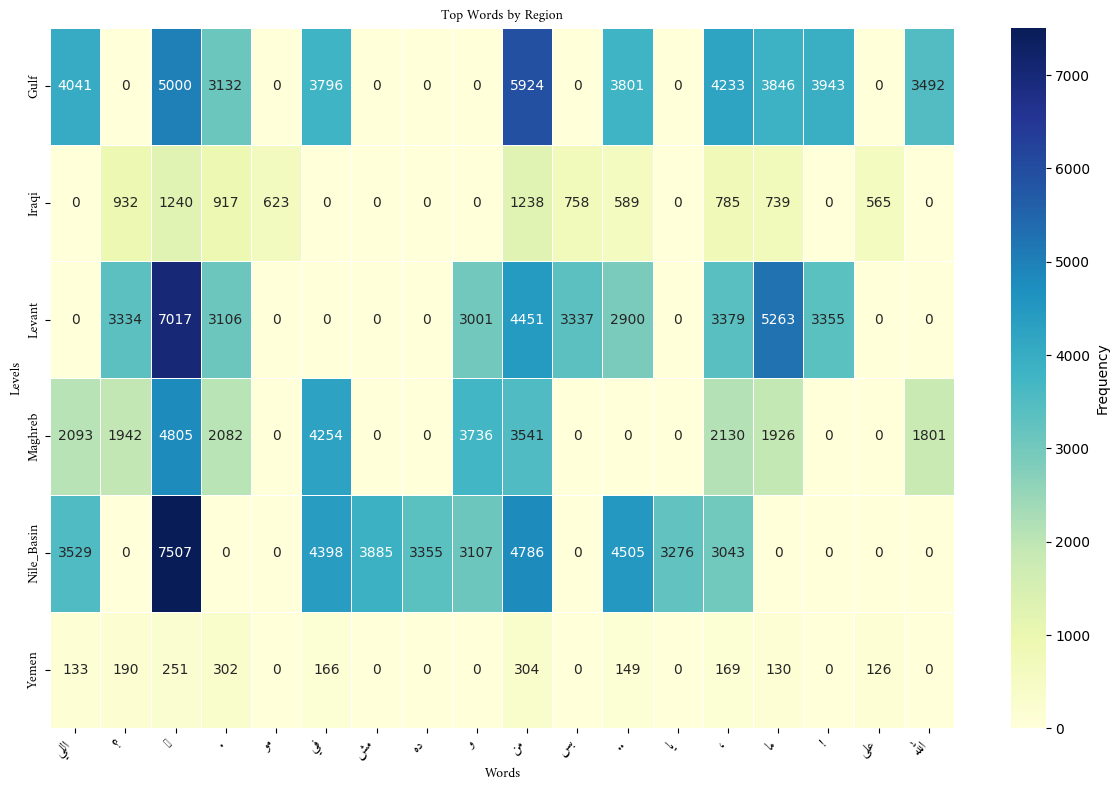

/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 65010 (\N{ARABIC LIGATURE ALLAH ISOLATED FORM}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
<ipython-input-69-e166cb173790>:39: UserWarning: Glyph 128514 (\N{FACE WITH TEARS OF JOY}) missing from font(s) Amiri.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128514 (\N{FACE WITH TEARS OF JOY}) missing from font(s) Amiri.
  fig.canvas.print_figure(bytes_io, **kw)


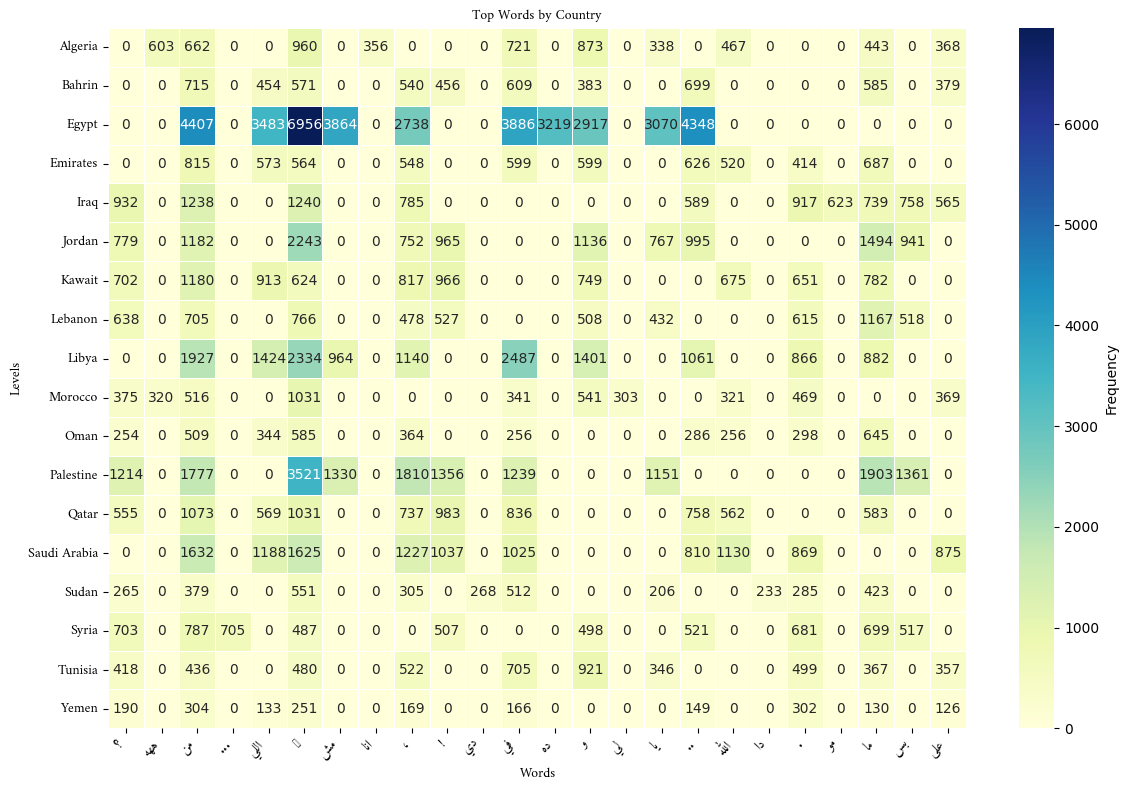

/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 65010 (\N{ARABIC LIGATURE ALLAH ISOLATED FORM}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
<ipython-input-69-e166cb173790>:39: UserWarning: Glyph 128514 (\N{FACE WITH TEARS OF JOY}) missing from font(s) Amiri.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128514 (\N{FACE WITH TEARS OF JOY}) missing from font(s) Amiri.
  fig.canvas.print_figure(bytes_io, **kw)


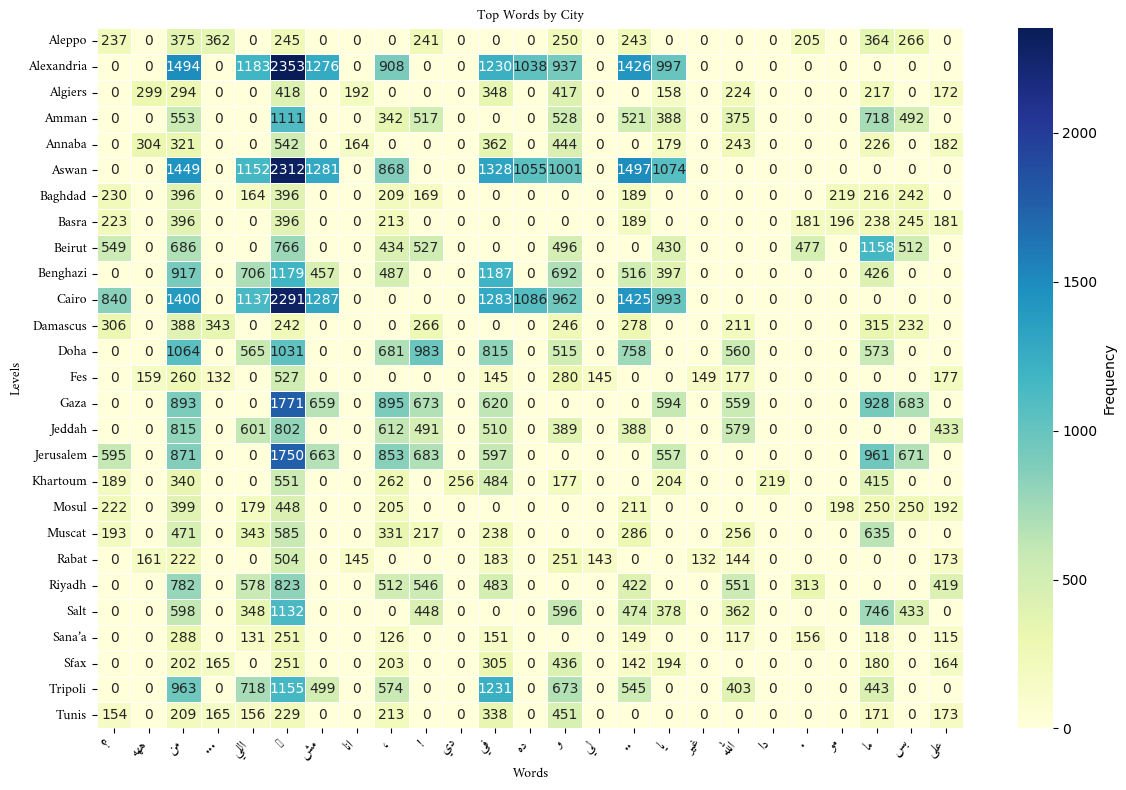

Number of rows in merged_train: 800068


In [ ]:
# reshape and reverse words
def reshape_arabic_text(text):
    return get_display(arabic_reshaper.reshape(text))

# to create a frequency matrix from the special words dictionary
def create_frequency_matrix(special_words, top_n=10):
    all_words = set()
    for words in special_words.values():
        all_words.update([word for word, _ in words[:top_n]])
    all_words = list(all_words)
    matrix = pd.DataFrame(0, index=special_words.keys(), columns=all_words)
    for level, words in special_words.items():
        for word, count in words[:top_n]:
            matrix.loc[level, word] = count
    return matrix

# plot heatmap
def plot_heatmap(data_matrix, title, font_path):
    # Load the font
    arabic_font = fm.FontProperties(fname=font_path)

    # Reshape column
    reshaped_columns = [reshape_arabic_text(col) for col in data_matrix.columns]
    reshaped_index = [reshape_arabic_text(idx) for idx in data_matrix.index]
    data_matrix.columns = reshaped_columns
    data_matrix.index = reshaped_index


    plt.figure(figsize=(12, 8))
    sns.heatmap(data_matrix, cmap="YlGnBu", annot=True, fmt="d", linewidths=0.5,
                cbar_kws={'label': 'Frequency'})


    plt.title(reshape_arabic_text(title), fontsize=16, fontproperties=arabic_font)
    plt.xlabel(reshape_arabic_text("Words"), fontproperties=arabic_font)
    plt.ylabel(reshape_arabic_text("Levels"), fontproperties=arabic_font)
    plt.xticks(fontproperties=arabic_font, rotation=45, ha="right")
    plt.yticks(fontproperties=arabic_font)
    plt.tight_layout()
    plt.show()


top_n_words = 10
font_path = "/content/Amiri-Regular.ttf"

region_matrix = create_frequency_matrix(region_special_words, top_n=top_n_words)
country_matrix = create_frequency_matrix(country_special_words, top_n=top_n_words)
city_matrix = create_frequency_matrix(city_special_words, top_n=top_n_words)

plot_heatmap(region_matrix, "Top Words by Region", font_path)
plot_heatmap(country_matrix, "Top Words by Country", font_path)
plot_heatmap(city_matrix, "Top Words by City", font_path)

# Print the number of rows in the merged_train DataFrame
print(f"Number of rows in merged_train: {len(merged_train)}")


## [2.7]

In [ ]:
###########glove#######3
# load GloVe embeddings
def load_glove_model(glove_file_path):
    print(f"Loading GloVe model from {glove_file_path}...")
    glove_model = {}
    with open(glove_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            glove_model[word] = vector
    print(f"Loaded {len(glove_model)} words from the GloVe model.")
    return glove_model


glove_file_path = "/content/glove.6B.100d.txt"
glove_model = load_glove_model(glove_file_path)

# compute the OOV words for each model
def check_oov(model, sentence):
    oov_count = 0
    tokens = sentence.split()
    vectors = []

    for word in tokens:
        if word in model:
            vectors.append(model[word])
        else:
            oov_count += 1  # Count the OOV word

    return oov_count, len(tokens), vectors

# compute the average word vector for each sentence
def get_average_vector(vectors):
    if len(vectors) == 0:
        return np.zeros(100)
    return np.mean(vectors, axis=0)

# Apply to the merged_train
def process_merged_train(df):
    oov_counts = []
    avg_vectors = []

    for _, row in df.iterrows():
        sentence = row['SENT']  #

        # Check for OOV words and get vectors for each sentence
        oov_count, total_tokens, vectors = check_oov(glove_model, sentence)

        # Compute the average word vector
        avg_vector = get_average_vector(vectors)

        oov_counts.append(oov_count / total_tokens if total_tokens > 0 else 0)
        avg_vectors.append(avg_vector)

    df['glove_oov'] = oov_counts
    df['avg_glove_vector'] = avg_vectors

    return df

merged_train_processed = process_merged_train(merged_train)


print(merged_train_processed[['SENT', 'glove_oov']].head())


Loading GloVe model from /content/glove.6B.100d.txt...
Loaded 400000 words from the GloVe model.
                                                SENT  glove_oov
0  @Ahmed_Hamza27 اتمنى صراحة و خصوصا #طال_عمره ب...   0.909091
1  @Ahmed_Hamza27 اتمنى صراحة و خصوصا #طال_عمره ب...   0.909091
2  @rJiM4CnIFTgml9g @zamnissi طبعا عرفته من اللي ...   0.875000
3  @rJiM4CnIFTgml9g @zamnissi طبعا عرفته من اللي ...   0.875000
4  @OmanisFollowers @ooredoo @TRA_OMAN @motc_om ه...   1.000000


In [ ]:
from google.colab import drive
import gzip
import numpy as np
import pandas as pd
import gc  # Import garbage collection

# Mount Google Drive
drive.mount('/content/drive')

# Define the paths
gz_file_path = "/content/drive/MyDrive/cc.en.300.vec.gz"
vec_file_path = "/content/cc.en.300.vec"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Decompress the gz file in smaller chunks
with gzip.open(gz_file_path, 'rt', encoding='utf-8') as gz_file:
    with open(vec_file_path, 'w', encoding='utf-8') as vec_file:
        print(f"Decompressing {gz_file_path} to {vec_file_path}...")
        chunk_size = 1024 * 1024  # 1 MB
        while True:
            chunk = gz_file.read(chunk_size)
            if not chunk:
                break
            vec_file.write(chunk)
print("Decompression complete.")

# Load FastText embeddings
def load_fasttext_model(fasttext_file_path):
    print(f"Loading FastText model from {fasttext_file_path}...")
    fasttext_model = {}
    with open(fasttext_file_path, 'r', encoding='utf-8') as f:
        next(f)  # Skip the first line (contains metadata)
        for line in f:
            values = line.strip().split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            fasttext_model[word] = vector
    print(f"Loaded {len(fasttext_model)} words from the FastText model.")
    return fasttext_model

fasttext_model = load_fasttext_model(vec_file_path)
gc.collect()  # Free up memory after loading the model

# Functions for OOV and average vector calculation
def check_oov(model, sentence):
    oov_count = 0
    tokens = sentence.split()  # Tokenizing the sentence (basic whitespace-based tokenization)
    vectors = []

    for word in tokens:
        if word in model:
            vectors.append(model[word])  # Use the word vector
        else:
            oov_count += 1  # Count the OOV word

    return oov_count, len(tokens), vectors

def get_average_vector(vectors):
    if len(vectors) == 0:
        return np.zeros(300)  # Return a zero vector if no valid word vectors are found
    return np.mean(vectors, axis=0)

def process_merged_train(df):
    oov_counts = []
    avg_vectors = []

    for _, row in df.iterrows():
        sentence = row['SENT']  # Access the sentence

        # Check for OOV words and get vectors for each sentence
        oov_count, total_tokens, vectors = check_oov(fasttext_model, sentence)

        # Compute the average word vector
        avg_vector = get_average_vector(vectors)

        oov_counts.append(oov_count / total_tokens if total_tokens > 0 else 0)  # OOV rate
        avg_vectors.append(avg_vector)

    df['fasttext_oov'] = oov_counts
    df['avg_fasttext_vector'] = avg_vectors

    return df

# Assuming you have a DataFrame 'merged_train' already loaded
merged_train_processed = process_merged_train(merged_train)
gc.collect()  # Free up memory after processing

print(merged_train_processed[['SENT', 'fasttext_oov']].head())
print(f"Number of rows in merged_train: {len(merged_train)}")


Decompressing /content/drive/MyDrive/cc.en.300.vec.gz to /content/cc.en.300.vec...
Decompression complete.
Loading FastText model from /content/cc.en.300.vec...
Loaded 2000000 words from the FastText model.
                                                SENT  fasttext_oov
0  @Ahmed_Hamza27 اتمنى صراحة و خصوصا #طال_عمره ب...      0.727273
1  @Ahmed_Hamza27 اتمنى صراحة و خصوصا #طال_عمره ب...      0.727273
2  @rJiM4CnIFTgml9g @zamnissi طبعا عرفته من اللي ...      0.875000
3  @rJiM4CnIFTgml9g @zamnissi طبعا عرفته من اللي ...      0.875000
4  @OmanisFollowers @ooredoo @TRA_OMAN @motc_om ه...      0.869565
Number of rows in merged_train: 800068


# مهمة 03 : تنظيف وتوحيد النص

normalization and cleaning Text

## [3.1]


In [ ]:
####0.3#

# convert unhashable types to strings
def safe_convert_to_str(x):
    """Converts unhashable types like lists or arrays to strings."""
    return str(x) if isinstance(x, (list, np.ndarray)) else x

# text cleaning functions
def remove_mentions(text):
    """Removes mentions in the form '@username'."""
    return re.sub(r'@\w+', '', text)

def remove_hashtags(text):
    """Removes hashtags but keeps the word after it."""
    return re.sub(r'#(\w+)', r'\1', text)

def remove_urls(text):
    """Removes URLs starting with 'http' or 'www'."""
    return re.sub(r'http[s]?://\S+', '', text)

def remove_non_arabic(text):
    """Removes all non-Arabic characters except spaces."""
    return re.sub(r'[^\u0600-\u06FF\s]', '', text)

def normalize_arabic(text):
    """Normalizes Arabic characters."""
    text = re.sub(r'[إأآا]', 'ا', text)
    text = re.sub(r'ة', 'ه', text)
    text = re.sub(r'[\u064B-\u065F]', '', text)
    return text

def remove_extra_whitespace(text):
    """Removes extra spaces, newlines, or tabs."""
    return re.sub(r'\s+', ' ', text).strip()

def clean_text(text):
    """Applies all cleaning steps to the input text."""
    if not isinstance(text, str):
        return ""
    text = remove_mentions(text)
    text = remove_hashtags(text)
    text = remove_urls(text)
    text = remove_non_arabic(text)
    text = normalize_arabic(text)
    return remove_extra_whitespace(text)

if __name__ == "__main__":
    sample_data = pd.DataFrame({
        'sent': [
            "@Ahmed_Hamza27 اتمنى صراحة و خصوصا #طال_عمره بينا وبينه قصة عشق قديمة😍😍",
            "@rJiM4CnIFTgml9g @zamnissi طبعا عرفته من اللي بشعار الليڤر",
            "@OmanisFollowers @ooredoo @TRA_OMAN @motc_om هيه هيه م يتغير شي.. كلهم ع بعضهم متولفين😪..",
            "كلب شو كنتوا بتتوقعوا منه !؟ محمود عباس لا يُمثل الا نفسه .",
            "#عزام 🔊 احنا ابو الولد وام الولد"
        ]
    })

    # Convert all entries to strings
    sample_data = sample_data.applymap(safe_convert_to_str)

    # Remove duplicated rows based on the 'sent' column
    sample_data = sample_data.drop_duplicates(subset=['sent']).reset_index(drop=True)

    # cleaning to the 'sent' column
    sample_data['cleaned_sent'] = sample_data['sent'].apply(clean_text)


    print(sample_data[['sent', 'cleaned_sent']].head())


# Print the number of rows in the merged_train DataFrame
print(f"Number of rows in merged_train: {len(merged_train)}")


                                                sent  \
0  @Ahmed_Hamza27 اتمنى صراحة و خصوصا #طال_عمره ب...   
1  @rJiM4CnIFTgml9g @zamnissi طبعا عرفته من اللي ...   
2  @OmanisFollowers @ooredoo @TRA_OMAN @motc_om ه...   
3  كلب شو كنتوا بتتوقعوا منه !؟ محمود عباس لا يُم...   
4                   #عزام 🔊 احنا ابو الولد وام الولد   

                                        cleaned_sent  
0  اتمنى صراحه و خصوصا طالعمره بينا وبينه قصه عشق...  
1                    طبعا عرفته من اللي بشعار الليڤر  
2            هيه هيه م يتغير شي كلهم ع بعضهم متولفين  
3  كلب شو كنتوا بتتوقعوا منه ؟ محمود عباس لا يمثل...  
4                      عزام احنا ابو الولد وام الولد  
Number of rows in merged_train: 800068


<ipython-input-70-f164771b9f66>:59: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  sample_data = sample_data.applymap(safe_convert_to_str)


In [ ]:
#######1.3###
# remove mentions (@username)
def remove_mentions(text):
    """Removes any mentions in the form of '@username'."""
    return re.sub(r'@\w+', '', text)

# remove hashtags
def remove_hashtags(text):
    """Removes hashtags but keeps the word after the hashtag."""
    return re.sub(r'#(\w+)', r'\1', text)

# remove URLs
def remove_urls(text):
    """Removes URLs starting with 'http' or 'www'."""
    return re.sub(r'http[s]?://\S+', '', text)

# remove non-Arabic characters
def remove_non_arabic(text):
    """Removes all non-Arabic characters except spaces."""
    return re.sub(r'[^\u0600-\u06FF\s]', '', text)

# normalize Arabic text
def normalize_arabic(text):
    """Normalizes Arabic characters like 'إ', 'أ', 'آ' to 'ا'."""
    text = re.sub(r'[إأآا]', 'ا', text)
    text = re.sub(r'ة', 'ه', text)
    text = re.sub(r'[\u064B-\u065F]', '', text)
    return text

# remove extra whitespace
def remove_extra_whitespace(text):
    """Removes extra spaces, newlines, or tabs."""
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

# all text cleaning steps
def clean_text(text):
    """Apply all cleaning functions to the text."""
    text = remove_mentions(text)
    text = remove_hashtags(text)
    text = remove_urls(text)
    text = remove_non_arabic(text)
    text = normalize_arabic(text)
    text = remove_extra_whitespace(text)
    return text

# Example usage
if __name__ == "__main__":
    # Sample dataset
    sentences = [
        "@Ahmed_Hamza27 اتمنى صراحة و خصوصا #طال_عمره بينا وبينه قصة عشق قديمة😍😍",
        "@rJiM4CnIFTgml9g @zamnissi طبعا عرفته من اللي بشعار الليڤر",
        "@OmanisFollowers @ooredoo @TRA_OMAN @motc_om هيه هيه م يتغير شي.. كلهم ع بعضهم متولفين😪..",
        "كلب شو كنتوا بتتوقعوا منه !؟ محمود عباس لا يُمثل الا نفسه .",
        "#عزام 🔊 احنا ابو الولد وام الولد"
    ]

    cleaned_sentences = [clean_text(sentence) for sentence in sentences]

    # Print the cleaned sentences
    for original, cleaned in zip(sentences, cleaned_sentences):
        print(f"Original: {original}")
        print(f"Cleaned: {cleaned}")
        print("-" * 50)

# Print the number of rows in the merged_train DataFrame
print(f"Number of rows in merged_train: {len(merged_train)}")


Original: @Ahmed_Hamza27 اتمنى صراحة و خصوصا #طال_عمره بينا وبينه قصة عشق قديمة😍😍
Cleaned: اتمنى صراحه و خصوصا طالعمره بينا وبينه قصه عشق قديمه
--------------------------------------------------
Original: @rJiM4CnIFTgml9g @zamnissi طبعا عرفته من اللي بشعار الليڤر
Cleaned: طبعا عرفته من اللي بشعار الليڤر
--------------------------------------------------
Original: @OmanisFollowers @ooredoo @TRA_OMAN @motc_om هيه هيه م يتغير شي.. كلهم ع بعضهم متولفين😪..
Cleaned: هيه هيه م يتغير شي كلهم ع بعضهم متولفين
--------------------------------------------------
Original: كلب شو كنتوا بتتوقعوا منه !؟ محمود عباس لا يُمثل الا نفسه .
Cleaned: كلب شو كنتوا بتتوقعوا منه ؟ محمود عباس لا يمثل الا نفسه
--------------------------------------------------
Original: #عزام 🔊 احنا ابو الولد وام الولد
Cleaned: عزام احنا ابو الولد وام الولد
--------------------------------------------------
Number of rows in merged_train: 800068


## [3.2]

In [ ]:
####2.3###
# Define all the text processing functions
def remove_mentions(text):
    """Removes mentions in the form '@username'."""
    return re.sub(r'@\w+', '', text)

def remove_hashtags(text):
    """Removes hashtags but keeps the word after it."""
    return re.sub(r'#(\w+)', r'\1', text)

def remove_urls(text):
    """Removes URLs starting with 'http' or 'www'."""
    return re.sub(r'http[s]?://\S+', '', text)

def remove_non_arabic(text):
    """Removes all non-Arabic characters except spaces."""
    return re.sub(r'[^\u0600-\u06FF\s]', '', text)

def normalize_arabic(text):
    """Normalizes Arabic characters."""
    text = re.sub(r'[إأآا]', 'ا', text)
    text = re.sub(r'ة', 'ه', text)
    text = re.sub(r'[\u064B-\u065F]', '', text)
    return text

def remove_extra_whitespace(text):
    """Removes extra spaces, newlines, or tabs."""
    return re.sub(r'\s+', ' ', text).strip()

# apply a sequence of functions
def process_text(text, function_names):

    for func_name in function_names:
        func = globals().get(func_name)
        if callable(func):
            text = func(text)
        else:
            raise ValueError(f"Function '{func_name}' is not defined.")
    return text

if __name__ == "__main__":
    # Sample text
    text = "@Ahmed_Hamza27 اتمنى صراحة و خصوصا #طال_عمره بينا وبينه قصة عشق قديمة😍😍"

    # processing steps
    processing_steps = ['remove_mentions', 'remove_hashtags', 'remove_urls', 'remove_non_arabic', 'normalize_arabic', 'remove_extra_whitespace']

    processed_text = process_text(text, processing_steps)

    print("Original Text:", text)
    print("Processed Text:", processed_text)

    # Print the number of rows in the merged_train DataFrame
print(f"Number of rows in merged_train: {len(merged_train)}")



Original Text: @Ahmed_Hamza27 اتمنى صراحة و خصوصا #طال_عمره بينا وبينه قصة عشق قديمة😍😍
Processed Text: اتمنى صراحه و خصوصا طالعمره بينا وبينه قصه عشق قديمه
Number of rows in merged_train: 800068


## [3.3]

In [ ]:

# List of cleaning funtions
processing_steps = [
    'remove_mentions',
    'remove_hashtags',
    'remove_urls',
    'remove_non_arabic',
    'normalize_arabic',
    'remove_extra_whitespace'
]

# count words in the dataset
def count_words(texts):
    all_words = " ".join(texts).split()
    total_words = len(all_words)
    unique_words = len(set(all_words))
    return total_words, unique_words

# words before cleaning
total_words_before, unique_words_before = count_words(merged_train['SENT'])

# Apply the cleaning function
merged_train['cleaned_sent'] = merged_train['SENT'].apply(lambda x: process_text(x, processing_steps))

# Count words after cleaning
total_words_after, unique_words_after = count_words(merged_train['cleaned_sent'])

print(f"Before Cleaning: Total Words = {total_words_before}, Unique Words = {unique_words_before}")
print(f"After Cleaning: Total Words = {total_words_after}, Unique Words = {unique_words_after}")

# Observations
observation = (
    f"Before cleaning, the dataset had {total_words_before} total words and {unique_words_before} unique words. "
    f"After cleaning, the dataset has {total_words_after} total words and {unique_words_after} unique words. "
    f"The cleaning process reduced noise such as mentions, URLs, and non-Arabic characters, which likely decreased the total and unique word counts."
)
print("Observation:", observation)

# Print the number of rows in the merged_train DataFrame
print(f"Number of rows in merged_train: {len(merged_train)}")


Before Cleaning: Total Words = 11599721, Unique Words = 889710
After Cleaning: Total Words = 10278215, Unique Words = 504069
Observation: Before cleaning, the dataset had 11599721 total words and 889710 unique words. After cleaning, the dataset has 10278215 total words and 504069 unique words. The cleaning process reduced noise such as mentions, URLs, and non-Arabic characters, which likely decreased the total and unique word counts.
Number of rows in merged_train: 800068


In [ ]:

# general cleaning function
def process_text(text, steps):
    for step in steps:
        text = globals()[step](text) if isinstance(text, str) else text
    return text

# processing steps
processing_steps = [
    'remove_mentions',
    'remove_hashtags',
    'remove_urls',
    'remove_non_arabic',
    'normalize_arabic',
    'remove_extra_whitespace'
]

#  count words in the dataset
def count_words(texts):
    all_words = " ".join(texts).split()
    total_words = len(all_words)
    unique_words = len(set(all_words))
    return total_words, unique_words

# words before cleaning
total_words_before, unique_words_before = count_words(merged_train['SENT'])

# Apply the cleaning function
merged_train['cleaned_sent'] = merged_train['SENT'].apply(lambda x: process_text(x, processing_steps))

#  words after cleaning
total_words_after, unique_words_after = count_words(merged_train['cleaned_sent'])

# Print results
print(f"Before Cleaning: Total Words = {total_words_before}, Unique Words = {unique_words_before}")
print(f"After Cleaning: Total Words = {total_words_after}, Unique Words = {unique_words_after}")

# Print the first five rows of the cleaned dataset
display(merged_train.head(10))

# Observations
observation = (
    f"Before cleaning, the dataset had {total_words_before} total words and {unique_words_before} unique words. "
    f"After cleaning, the dataset has {total_words_after} total words and {unique_words_after} unique words. "
    f"The cleaning process reduced noise such as mentions, URLs, and non-Arabic characters, which likely decreased the total and unique word counts."
)
print("Observation:", observation)

# Print the number of rows in the merged_train DataFrame
print(f"Number of rows in merged_train: {len(merged_train)}")


## [3.4]

In [ ]:
# Check for empty or short sentences (<5 characters) and remove them

# number of rows in merged_train before deletion
print(f"Number of rows in merged_train before deletion: {len(merged_train)}")

# rows with empty or very short sentences
short_or_empty_rows = merged_train[merged_train['cleaned_sent'].str.len() < 5]

# number of short rows
short_or_empty_count = len(short_or_empty_rows)
print(f"Number of rows with empty or very short sentences (<5 characters): {short_or_empty_count}")

# Remove short rows
merged_train = merged_train[merged_train['cleaned_sent'].str.len() >= 5].reset_index(drop=True)

# updated number of rows
print(f"Number of rows in merged_train after deletion: {len(merged_train)}")


# مهمة 04  : بناء النموذج المرجعي

Model Baseline

## [4.1]


In [ ]:
# Extract X and Y for training, validation, and test datasets

# Training dataset
X_train_raw = merged_train['SENT']  # Input features
Y_train_raw = merged_train['COUNTRY']  # Target labels

# Validation dataset
X_validation_raw = merged_validation['sent']  # Input features
Y_validation_raw = merged_validation['Country']  # Target labels

# Test dataset
X_test_raw = merged_test['sent']  # Input features
Y_test_raw = merged_test['Country']  # Target labels

# Print the shapes to confirm the extraction
print(f"Training Data: X_train_raw shape = {X_train_raw.shape}, Y_train_raw shape = {Y_train_raw.shape}")
print(f"Validation Data: X_validation_raw shape = {X_validation_raw.shape}, Y_validation_raw shape = {Y_validation_raw.shape}")
print(f"Test Data: X_test_raw shape = {X_test_raw.shape}, Y_test_raw shape = {Y_test_raw.shape}")


## [4.2]

In [ ]:
# Extract columns and handle NaN values
X_train_raw = merged_train['SENT']
Y_train_raw = merged_train['COUNTRY']
X_validation_raw = merged_validation['sent']
Y_validation_raw = merged_validation['Country']
X_test_raw = merged_test['sent']
Y_test_raw = merged_test['Country']

# Combine X and Y, then drop rows with NaN values
train_data = pd.concat([X_train_raw, Y_train_raw], axis=1).dropna()
X_train_raw = train_data['SENT']
Y_train_raw = train_data['COUNTRY']

validation_data = pd.concat([X_validation_raw, Y_validation_raw], axis=1).dropna()
X_validation_raw = validation_data['sent']
Y_validation_raw = validation_data['Country']

test_data = pd.concat([X_test_raw, Y_test_raw], axis=1).dropna()
X_test_raw = test_data['sent']
Y_test_raw = test_data['Country']

# TF-IDF Vectorizer and Multinomial Naive Bayes
vectorizer = TfidfVectorizer()
nb_model = MultinomialNB()

# Vectorize the data
X_train_vectorized = vectorizer.fit_transform(X_train_raw)
X_validation_vectorized = vectorizer.transform(X_validation_raw)
X_test_vectorized = vectorizer.transform(X_test_raw)

# Train the model
nb_model.fit(X_train_vectorized, Y_train_raw)

print("Model trained and vectorizer built.")


## [4.3]

In [ ]:
# Evaluate model
def evaluate_model(model, X_train, Y_train, X_validation, Y_validation, model_name, features, model_parameters, preprocessing_methods, comparison_table):
    model.fit(X_train, Y_train)

    # Predict on the validation set
    Y_pred = model.predict(X_validation)

    # Compute accuracy, balanced accuracy, and f1-score (weighted)
    accuracy = accuracy_score(Y_validation, Y_pred)
    balanced_accuracy = balanced_accuracy_score(Y_validation, Y_pred)
    f_score = f1_score(Y_validation, Y_pred, average='weighted')

    # Store results in the comparison table
    comparison_table['question_step_number'].append(4.3)
    comparison_table['model_name'].append(model_name)
    comparison_table['features'].append(features)
    comparison_table['model_parameters'].append(model_parameters)
    comparison_table['preprocessing_methods'].append(preprocessing_methods)
    comparison_table['accuracy'].append(accuracy)
    comparison_table['balanced_accuracy'].append(balanced_accuracy)
    comparison_table['f_score'].append(f_score)

# Extract X and Y for training, validation, and test datasets
X_train_raw = merged_train['SENT']
Y_train_raw = merged_train['COUNTRY']

X_validation_raw = merged_validation['sent']
Y_validation_raw = merged_validation['Country']

X_test_raw = merged_test['sent']
Y_test_raw = merged_test['Country']

# Check for NaN values and drop rows with NaN
train_data = pd.concat([X_train_raw, Y_train_raw], axis=1).dropna()
X_train_raw = train_data['SENT']
Y_train_raw = train_data['COUNTRY']

validation_data = pd.concat([X_validation_raw, Y_validation_raw], axis=1).dropna()
X_validation_raw = validation_data['sent']
Y_validation_raw = validation_data['Country']

test_data = pd.concat([X_test_raw, Y_test_raw], axis=1).dropna()
X_test_raw = test_data['sent']
Y_test_raw = test_data['Country']

# Vectorization using TF-IDF
vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train_raw)
X_validation_vectorized = vectorizer.transform(X_validation_raw)
X_test_vectorized = vectorizer.transform(X_test_raw)

# Naive Bayes model
nb_model = MultinomialNB()

# Create comparison table
comparison_table = {
    'question_step_number': [],
    'model_name': [],
    'features': [],
    'model_parameters': [],
    'preprocessing_methods': [],
    'accuracy': [],
    'balanced_accuracy': [],
    'f_score': []
}

# Evaluate on the validation set
evaluate_model(
    model=nb_model,
    X_train=X_train_vectorized,
    Y_train=Y_train_raw,
    X_validation=X_validation_vectorized,
    Y_validation=Y_validation_raw,
    model_name="Naive Bayes",
    features="TF-IDF Vectorization",
    model_parameters="alpha=1.0",
    preprocessing_methods="None",
    comparison_table=comparison_table
)

print(comparison_table)

# Predict on test data
Y_test_pred = nb_model.predict(X_test_vectorized)

# Accuracy, balanced accuracy, and f1-score on the test data
test_accuracy = accuracy_score(Y_test_raw, Y_test_pred)
test_balanced_accuracy = balanced_accuracy_score(Y_test_raw, Y_test_pred)
test_f_score = f1_score(Y_test_raw, Y_test_pred, average='weighted')

# Print the test results
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Balanced Accuracy: {test_balanced_accuracy}")
print(f"Test F-Score (Weighted): {test_f_score}")

# Add the test results to the comparison table
comparison_table['question_step_number'].append(5)
comparison_table['model_name'].append("Naive Bayes")
comparison_table['features'].append("TF-IDF Vectorization")
comparison_table['model_parameters'].append("alpha=1.0")
comparison_table['preprocessing_methods'].append("None")
comparison_table['accuracy'].append(test_accuracy)
comparison_table['balanced_accuracy'].append(test_balanced_accuracy)
comparison_table['f_score'].append(test_f_score)

comparison_df = pd.DataFrame(comparison_table)

# Display the comparison table
display(comparison_df)


## [4.4]

In [ ]:
comparison_table = {
    'question_step_number': [],
    'model_name': [],
    'features': [],
    'model_parameters': [],
    'preprocessing_methods': [],
    'accuracy': [],
    'balanced_accuracy': [],
    'f_score': [],
}

def evaluate_single_method(cleaning_method, X_train_raw, Y_train_raw, X_validation_raw, Y_validation_raw):

    # Apply the cleaning method to train and validation data
    X_train_cleaned = X_train_raw.apply(lambda x: globals()[cleaning_method](x))
    X_validation_cleaned = X_validation_raw.apply(lambda x: globals()[cleaning_method](x))

    # Vectorize the cleaned data using TF-IDF
    vectorizer = TfidfVectorizer()
    X_train_vectorized = vectorizer.fit_transform(X_train_cleaned)
    X_validation_vectorized = vectorizer.transform(X_validation_cleaned)

    # Train the Naive Bayes model
    model = MultinomialNB()
    model.fit(X_train_vectorized, Y_train_raw)

    Y_validation_pred = model.predict(X_validation_vectorized)
    accuracy = accuracy_score(Y_validation_raw, Y_validation_pred)
    balanced_accuracy = balanced_accuracy_score(Y_validation_raw, Y_validation_pred)
    f_score = f1_score(Y_validation_raw, Y_validation_pred, average='weighted')

    # Log results into the comparison table
    comparison_table['question_step_number'].append(4.4)
    comparison_table['model_name'].append("Multinomial Naive Bayes")
    comparison_table['features'].append("TF-IDF Vectorization")
    comparison_table['model_parameters'].append("alpha=1.0")
    comparison_table['preprocessing_methods'].append(cleaning_method)
    comparison_table['accuracy'].append(accuracy)
    comparison_table['balanced_accuracy'].append(balanced_accuracy)
    comparison_table['f_score'].append(f_score)

    # Display results of the chosen cleaning method
    print(f"Cleaning Method: {cleaning_method}")
    print(f"Validation Accuracy: {accuracy:.4f}")
    print(f"Balanced Accuracy: {balanced_accuracy:.4f}")
    print(f"F-Score (Weighted): {f_score:.4f}")
    print("-" * 50)

    return {
        "method": cleaning_method,
        "accuracy": accuracy,
        "balanced_accuracy": balanced_accuracy,
        "f_score": f_score
    }

cleaning_methods = [
    'remove_mentions',
    'remove_hashtags',
    'remove_urls',
    'remove_non_arabic',
    'normalize_arabic',
    'remove_extra_whitespace'
]

for method in cleaning_methods:
    print(f"Evaluating {method}...")
    evaluate_single_method(
        cleaning_method=method,
        X_train_raw=X_train_raw,
        Y_train_raw=Y_train_raw,
        X_validation_raw=X_validation_raw,
        Y_validation_raw=Y_validation_raw
    )

comparison_df = pd.DataFrame(comparison_table)
display(comparison_df)


## [4.5]

In [ ]:
# initialize comparison_table
if "comparison_table" not in globals() or any(len(values) != len(comparison_table['question_step_number']) for values in comparison_table.values()):
    comparison_table = {
        "question_step_number": [],
        "model_name": [],
        "features": [],
        "model_parameters": [],
        "preprocessing_methods": [],
        "accuracy": [],
        "balanced_accuracy": [],
        "f_score": [],
    }

# selected cleaning methods based on Task 4-4 results
selected_methods = ["remove_urls"]

# Apply cleaning methods to datasets
def apply_cleaning_methods(dataset, methods):
    return dataset.apply(lambda x: process_text(x, methods))

cleaned_X_train = apply_cleaning_methods(X_train_raw, selected_methods)
cleaned_X_validation = apply_cleaning_methods(X_validation_raw, selected_methods)
cleaned_X_test = apply_cleaning_methods(X_test_raw, selected_methods)

# Vectorize cleaned datasets using TF-IDF
vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(cleaned_X_train)
X_validation_vectorized = vectorizer.transform(cleaned_X_validation)
X_test_vectorized = vectorizer.transform(cleaned_X_test)

# Train the Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train_vectorized, Y_train_raw)

# Evaluate on validation data
Y_validation_pred = nb_model.predict(X_validation_vectorized)
validation_accuracy = accuracy_score(Y_validation_raw, Y_validation_pred)
balanced_accuracy_val = balanced_accuracy_score(Y_validation_raw, Y_validation_pred)
f1_score_val = f1_score(Y_validation_raw, Y_validation_pred, average="weighted")

# Evaluate on test data
Y_test_pred = nb_model.predict(X_test_vectorized)
test_accuracy = accuracy_score(Y_test_raw, Y_test_pred)
balanced_accuracy_test = balanced_accuracy_score(Y_test_raw, Y_test_pred)
f1_score_test = f1_score(Y_test_raw, Y_test_pred, average="weighted")

# Append results to comparison_table
comparison_table["question_step_number"].append(4.5)
comparison_table["model_name"].append("Multinomial Naive Bayes")
comparison_table["features"].append("TF-IDF Vectorization")
comparison_table["model_parameters"].append("alpha=1.0")
comparison_table["preprocessing_methods"].append(", ".join(selected_methods))
comparison_table["accuracy"].append(test_accuracy)
comparison_table["balanced_accuracy"].append(balanced_accuracy_test)
comparison_table["f_score"].append(f1_score_test)

# Validate lengths of all keys in comparison_table before creating the DataFrame
for key, value in comparison_table.items():
    assert len(value) == len(comparison_table["question_step_number"]), f"Mismatch in lengths for key: {key}"

# Display the updated comparison table
comparison_df = pd.DataFrame(comparison_table)
display(comparison_df)


## [4.6]

In [ ]:

# parameter grid for TF-IDF
tfidf_param_grid = {
    "max_df": [0.8, 0.9, 1.0],  # Ignore terms that appear in more than x% of documents
    "min_df": [1, 2, 5],  # Ignore terms that appear in fewer than x documents
    "ngram_range": [(1, 1), (1, 2)],
}

# Initialize the model and vectorizer
nb_model = MultinomialNB()
best_model = None
best_vectorizer = None
best_validation_accuracy = 0
best_params = {}

# Grid search on parameters
for max_df in tfidf_param_grid["max_df"]:
    for min_df in tfidf_param_grid["min_df"]:
        for ngram_range in tfidf_param_grid["ngram_range"]:
            # Initialize TF-IDF vectorizer with current parameters
            vectorizer = TfidfVectorizer(max_df=max_df, min_df=min_df, ngram_range=ngram_range)

            # Transform training and validation data
            X_train_vectorized = vectorizer.fit_transform(X_train_raw)
            X_validation_vectorized = vectorizer.transform(X_validation_raw)

            nb_model.fit(X_train_vectorized, Y_train_raw)

            # Evaluate
            Y_validation_pred = nb_model.predict(X_validation_vectorized)
            validation_accuracy = accuracy_score(Y_validation_raw, Y_validation_pred)

            # Check if this is the best model so far
            if validation_accuracy > best_validation_accuracy:
                best_validation_accuracy = validation_accuracy
                best_params = {
                    "max_df": max_df,
                    "min_df": min_df,
                    "ngram_range": ngram_range,
                }
                best_model = nb_model
                best_vectorizer = vectorizer

comparison_table["question_step_number"].append(4.6)
comparison_table["model_name"].append("Multinomial Naive Bayes")
comparison_table["features"].append("TF-IDF")
comparison_table["model_parameters"].append(str(best_params))
comparison_table["preprocessing_methods"].append("None (Raw Data)")
comparison_table["accuracy"].append(best_validation_accuracy)
comparison_table["balanced_accuracy"].append(None)
comparison_table["f_score"].append(None)

print("Best TF-IDF Parameters:", best_params)
print(f"Best Validation Accuracy: {best_validation_accuracy:.4f}")

# updated comparison table
comparison_df = pd.DataFrame(comparison_table)
display(comparison_df)


Best TF-IDF Parameters: {'max_df': 0.8, 'min_df': 5, 'ngram_range': (1, 1)}
Best Validation Accuracy: 0.6072


,question_step_number,model_name,features,model_parameters,preprocessing_methods,accuracy,balanced_accuracy,f_score
0,4.4,Multinomial Naive Bayes,TF-IDF Vectorization,alpha=1.0,remove_mentions,0.430941,0.258322,0.375133
1,4.4,Multinomial Naive Bayes,TF-IDF Vectorization,alpha=1.0,remove_hashtags,0.500340,0.328090,0.460158
2,4.4,Multinomial Naive Bayes,TF-IDF Vectorization,alpha=1.0,remove_urls,0.506857,0.335971,0.467672
3,4.4,Multinomial Naive Bayes,TF-IDF Vectorization,alpha=1.0,remove_non_arabic,0.438236,0.266185,0.383622
4,4.4,Multinomial Naive Bayes,TF-IDF Vectorization,alpha=1.0,normalize_arabic,0.500875,0.328813,0.461266
5,4.4,Multinomial Naive Bayes,TF-IDF Vectorization,alpha=1.0,remove_extra_whitespace,0.500438,0.328221,0.460273
6,4.5,Multinomial Naive Bayes,TF-IDF Vectorization,alpha=1.0,remove_urls,0.500222,0.329980,0.461764
7,4.6,Multinomial Naive Bayes,TF-IDF,"{'max_df': 0.8, 'min_df': 5, 'ngram_range': (1...",None (Raw Data),0.607188,NaN,NaN
8,4.6,Multinomial Naive Bayes,TF-IDF,"{'max_df': 0.8, 'min_df': 5, 'ngram_range': (1...",None (Raw Data),0.607188,NaN,NaN


# مهمة 05 : التدريب باستخدام نماذج التعلم العميق

Deep learning

The Comparison Dictionary example

In [ ]:
comparison_table = {}

comparison_table['question_step_number'] = []
comparison_table['model_name'] = []
comparison_table['features'] = []
comparison_table['model_parameters'] = []
comparison_table['preprocessing_methods'] = []
comparison_table['accuracy'] = []
comparison_table['balance_accuracy'] = []

Filling the dictionary example

In [ ]:
# comparison_table['question_step_number'].append("3.5")
# comparison_table['model_name'].append('logistic_regression')
# comparison_table['features'].append('bag of words')
# comparison_table['model_parameters'].append('default')
# comparison_table['preprocessing_methods'].append("remove links")
# comparison_table['accuracy'].append(accuracy)
# comparison_table['balance_accuracy'].append(balance_accuracy_value)

## [5.1]

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import balanced_accuracy_score, f1_score
import tensorflow as tf
import pandas as pd

# Step 1: Apply the cleaning methods (if necessary)
selected_cleaning_methods = ["remove_urls"]

def apply_cleaning_methods(dataset, methods):
    return dataset.apply(lambda x: process_text(x, methods))

cleaned_X_train = apply_cleaning_methods(X_train_raw, selected_cleaning_methods)
cleaned_X_validation = apply_cleaning_methods(X_validation_raw, selected_cleaning_methods)
cleaned_X_test = apply_cleaning_methods(X_test_raw, selected_cleaning_methods)

# Step 2: TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(cleaned_X_train)
X_validation_tfidf = tfidf_vectorizer.transform(cleaned_X_validation)
X_test_tfidf = tfidf_vectorizer.transform(cleaned_X_test)

# Step 3: Encode the target labels
onehot_encoder = OneHotEncoder(sparse_output=False)
Y_train_onehot = onehot_encoder.fit_transform(Y_train_raw.to_numpy().reshape(-1, 1))
Y_validation_onehot = onehot_encoder.transform(Y_validation_raw.to_numpy().reshape(-1, 1))
Y_test_onehot = onehot_encoder.transform(Y_test_raw.to_numpy().reshape(-1, 1))

# Step 4: Build the deep learning model
model = Sequential([
    InputLayer(input_shape=(X_train_tfidf.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(18, activation='softmax')
])

# Step 5: Compile the model
optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping and learning rate scheduler
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Compute class weights
class_weights = class_weight.compute_class_weight(
    'balanced', classes=np.unique(Y_train_raw), y=Y_train_raw
)
class_weights = dict(enumerate(class_weights))

# Convert the data into TensorFlow Datasets for batch processing
def to_tensorflow_datasets(X, Y):
    def generator():
        for i in range(X.shape[0]):
            yield X[i].toarray().astype(np.float32).reshape(-1), Y[i].astype(np.float32)
    return tf.data.Dataset.from_generator(generator, output_signature=(
        tf.TensorSpec(shape=(X.shape[1],), dtype=tf.float32),
        tf.TensorSpec(shape=(Y.shape[1],), dtype=tf.float32)
    )).batch(32).repeat()

train_dataset = to_tensorflow_datasets(X_train_tfidf, Y_train_onehot)
validation_dataset = to_tensorflow_datasets(X_validation_tfidf, Y_validation_onehot)

# Define steps per epoch and validation steps
steps_per_epoch = X_train_tfidf.shape[0] // 32
validation_steps = X_validation_tfidf.shape[0] // 32

# Print steps per epoch and validation steps
print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")

# Step 8: Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    class_weight=class_weights,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

# Step 9: Evaluate the model
test_dataset = to_tensorflow_datasets(X_test_tfidf, Y_test_onehot)
train_loss, train_accuracy = model.evaluate(train_dataset, steps=steps_per_epoch, verbose=0)
test_loss, test_accuracy = model.evaluate(test_dataset, steps=validation_steps, verbose=0)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

# Predict and calculate additional metrics
Y_test_pred_proba = model.predict(test_dataset, steps=validation_steps, verbose=0)
Y_test_pred = np.argmax(Y_test_pred_proba, axis=1)

balanced_accuracy = balanced_accuracy_score(Y_test_encoded, Y_test_pred)
f1_score_weighted = f1_score(Y_test_encoded, Y_test_pred, average='weighted')

print(f"Balanced Accuracy: {balanced_accuracy:.4f}")
print(f"F1 Score (Weighted): {f1_score_weighted:.4f}")

# Step 10: Log the results into a comparison table
if "comparison_table" not in globals():
    comparison_table = {
        "question_step_number": [],
        "model_name": [],
        "features": [],
        "model_parameters": [],
        "preprocessing_methods": [],
        "accuracy": [],
        "balanced_accuracy": [],
        "f_score": [],
    }

comparison_table["question_step_number"].append(5)
comparison_table["model_name"].append("Deep Learning (Dense Layers with TF-IDF)")
comparison_table["features"].append("TF-IDF Features")
comparison_table["model_parameters"].append("Dense(64,32), Softmax")
comparison_table["preprocessing_methods"].append(", ".join(selected_cleaning_methods))
comparison_table["accuracy"].append(test_accuracy)
comparison_table["balanced_accuracy"].append(balanced_accuracy)
comparison_table["f_score"].append(f1_score_weighted)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Steps per epoch: 24942
Validation steps: 642
Epoch 1/10
24942/24942 ━━━━━━━━━━━━━━━━━━━━ 525s 21ms/step - accuracy: 0.2313 - loss: 2.6527 - val_accuracy: 0.3651 - val_loss: 2.0832 - learning_rate: 1.0000e-04
Epoch 2/10
24942/24942 ━━━━━━━━━━━━━━━━━━━━ 524s 21ms/step - accuracy: 0.3769 - loss: 2.1595 - val_accuracy: 0.4079 - val_loss: 1.9293 - learning_rate: 1.0000e-04
Epoch 3/10
24942/24942 ━━━━━━━━━━━━━━━━━━━━ 522s 21ms/step - accuracy: 0.4100 - loss: 2.0595 - val_accuracy: 0.4279 - val_loss: 1.8732 - learning_rate: 1.0000e-04
Epoch 4/10
24942/24942 ━━━━━━━━━━━━━━━━━━━━ 524s 21ms/step - accuracy: 0.4255 - loss: 2.0109 - val_accuracy: 0.4343 - val_loss: 1.8425 - learning_rate: 1.0000e-04
Epoch 5/10
24942/24942 ━━━━━━━━━━━━━━━━━━━━ 523s 21ms/step - accuracy: 0.4346 - loss: 1.9831 - val_accuracy: 0.4388 - val_loss: 1.8211 - learning_rate: 1.0000e-04
Epoch 6/10
24942/24942 ━━━━━━━━━━━━━━━━━━━━ 520s 21ms/step - accuracy: 0.4393 - loss: 1.9636 - val_accuracy: 0.4412 - val_loss: 1.8098 - lea

NameError: name 'Y_test_encoded' is not defined

In [87]:

# Display the updated comparison table
comparison_df = pd.DataFrame(comparison_table)
display(comparison_df)


,question_step_number,model_name,features,model_parameters,preprocessing_methods,accuracy,balanced_accuracy,f_score
0,4.4,Multinomial Naive Bayes,TF-IDF Vectorization,alpha=1.0,remove_mentions,0.430941,0.258322,0.375133
1,4.4,Multinomial Naive Bayes,TF-IDF Vectorization,alpha=1.0,remove_hashtags,0.500340,0.328090,0.460158
2,4.4,Multinomial Naive Bayes,TF-IDF Vectorization,alpha=1.0,remove_urls,0.506857,0.335971,0.467672
3,4.4,Multinomial Naive Bayes,TF-IDF Vectorization,alpha=1.0,remove_non_arabic,0.438236,0.266185,0.383622
4,4.4,Multinomial Naive Bayes,TF-IDF Vectorization,alpha=1.0,normalize_arabic,0.500875,0.328813,0.461266
5,4.4,Multinomial Naive Bayes,TF-IDF Vectorization,alpha=1.0,remove_extra_whitespace,0.500438,0.328221,0.460273
6,4.5,Multinomial Naive Bayes,TF-IDF Vectorization,alpha=1.0,remove_urls,0.500222,0.329980,0.461764
7,4.6,Multinomial Naive Bayes,TF-IDF,"{'max_df': 0.8, 'min_df': 5, 'ngram_range': (1...",None (Raw Data),0.607188,NaN,NaN
8,4.6,Multinomial Naive Bayes,TF-IDF,"{'max_df': 0.8, 'min_df': 5, 'ngram_range': (1...",None (Raw Data),0.607188,NaN,NaN


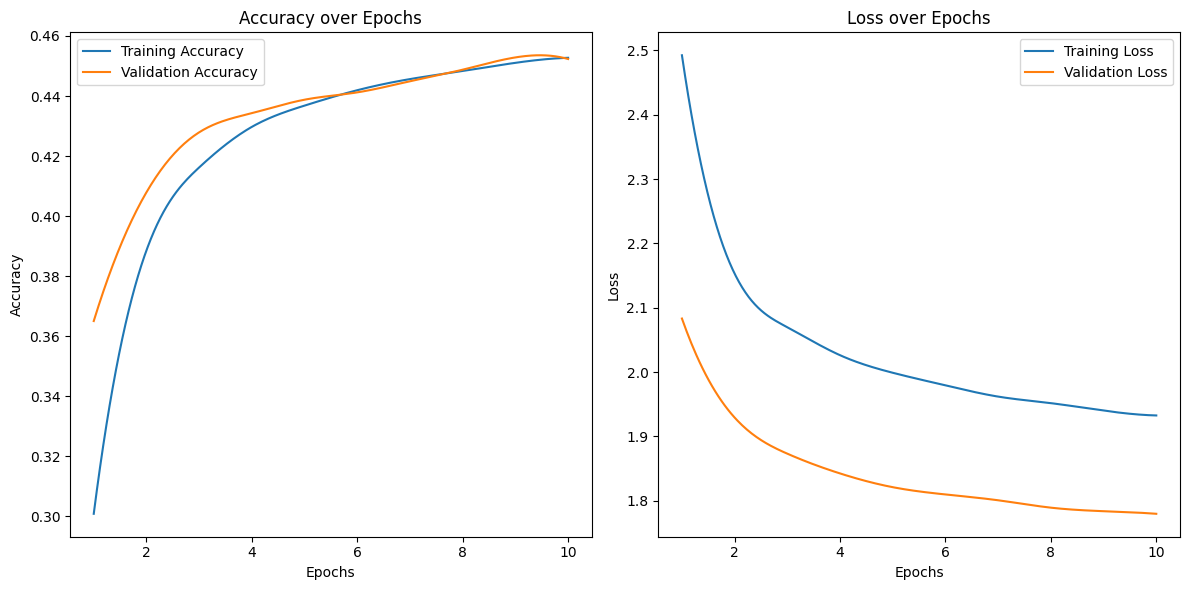

In [88]:

from scipy.interpolate import make_interp_spline as mis

# Define epochs
epochs = np.arange(1, len(history.history['loss']) + 1)

# This is for making the curves smoother
epochs_smooth = np.linspace(epochs.min(), epochs.max(), 300)
loss_smooth = mis(epochs, history.history['loss'])(epochs_smooth)
val_loss_smooth = mis(epochs, history.history['val_loss'])(epochs_smooth)
accuracy_smooth = mis(epochs, history.history['accuracy'])(epochs_smooth)
val_accuracy_smooth = mis(epochs, history.history['val_accuracy'])(epochs_smooth)

# Step 1: Plot Accuracy
plt.figure(figsize=(12, 6))

# Training and Validation Accuracy with smoothing
plt.subplot(1, 2, 1)
plt.plot(epochs_smooth, accuracy_smooth, label='Training Accuracy')
plt.plot(epochs_smooth, val_accuracy_smooth, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Step 2: Plot Loss with smoothing
plt.subplot(1, 2, 2)
plt.plot(epochs_smooth, loss_smooth, label='Training Loss')
plt.plot(epochs_smooth, val_loss_smooth, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


## [5.2]

### [5.2.1]

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

max_vocab_size = 10000  # Maximum vocabulary size
max_sequence_length = 200  # Maximum length of text sequences

tokenizer = Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(cleaned_X_train)

X_train_seq = tokenizer.texts_to_sequences(cleaned_X_train)
X_validation_seq = tokenizer.texts_to_sequences(cleaned_X_validation)
X_test_seq = tokenizer.texts_to_sequences(cleaned_X_test)

X_train_padded = pad_sequences(X_train_seq, maxlen=max_sequence_length, padding='post')
X_validation_padded = pad_sequences(X_validation_seq, maxlen=max_sequence_length, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_sequence_length, padding='post')

label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train_raw)
Y_validation_encoded = label_encoder.transform(Y_validation_raw)
Y_test_encoded = label_encoder.transform(Y_test_raw)

onehot_encoder = OneHotEncoder(sparse_output=False)
Y_train_onehot = onehot_encoder.fit_transform(Y_train_encoded.reshape(-1, 1))
Y_validation_onehot = onehot_encoder.transform(Y_validation_encoded.reshape(-1, 1))
Y_test_onehot = onehot_encoder.transform(Y_test_encoded.reshape(-1, 1))

embedding_dim = 100

model = Sequential([
    Input(shape=(max_sequence_length,)),
    Embedding(input_dim=max_vocab_size, output_dim=embedding_dim, input_length=max_sequence_length, trainable=True),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(Y_train_onehot.shape[1], activation='softmax')
])

optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

history = model.fit(
    X_train_padded,
    Y_train_onehot,
    validation_data=(X_validation_padded, Y_validation_onehot),
    epochs=10,
    batch_size=64,
    class_weight=class_weights,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

train_loss, train_accuracy = model.evaluate(X_train_padded, Y_train_onehot, verbose=0)
test_loss, test_accuracy = model.evaluate(X_test_padded, Y_test_onehot, verbose=0)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

Y_test_pred_proba = model.predict(X_test_padded, verbose=0)
Y_test_pred = np.argmax(Y_test_pred_proba, axis=1)

balanced_accuracy = balanced_accuracy_score(Y_test_encoded, Y_test_pred)
f1_score_weighted = f1_score(Y_test_encoded, Y_test_pred, average='weighted')

print(f"Balanced Accuracy: {balanced_accuracy:.4f}")
print(f"F1 Score (Weighted): {f1_score_weighted:.4f}")

comparison_table["question_step_number"].append("5.2.1")
comparison_table["model_name"].append("CNN (Trainable Embedding)")
comparison_table["features"].append("Trainable Embedding Layer")
comparison_table["model_parameters"].append("Conv1D(128), Dense(64), Softmax")
comparison_table["preprocessing_methods"].append(", ".join(selected_cleaning_methods))
comparison_table["accuracy"].append(test_accuracy)
comparison_table["balanced_accuracy"].append(balanced_accuracy)
comparison_table["f_score"].append(f1_score_weighted)



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
12472/12472 ━━━━━━━━━━━━━━━━━━━━ 1534s 123ms/step - accuracy: 0.2306 - loss: 2.5548 - val_accuracy: 0.4622 - val_loss: 1.7447 - learning_rate: 1.0000e-04
Epoch 2/10
12472/12472 ━━━━━━━━━━━━━━━━━━━━ 1584s 123ms/step - accuracy: 0.4723 - loss: 1.8306 - val_accuracy: 0.4944 - val_loss: 1.6306 - learning_rate: 1.0000e-04
Epoch 3/10
12472/12472 ━━━━━━━━━━━━━━━━━━━━ 1593s 124ms/step - accuracy: 0.5139 - loss: 1.6945 - val_accuracy: 0.5081 - val_loss: 1.5973 - learning_rate: 1.0000e-04
Epoch 4/10
12472/12472 ━━━━━━━━━━━━━━━━━━━━ 1578s 124ms/step - accuracy: 0.5333 - loss: 1.6156 - val_accuracy: 0.5140 - val_loss: 1.5578 - learning_rate: 1.0000e-04
Epoch 5/10
 1082/12472 ━━━━━━━━━━━━━━━━━━━━ 23:04 122ms/step - accuracy: 0.5488 - loss: 1.5506